In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


## EDA

In [4]:
df.shape

(42, 2)

In [5]:
#Checking the data types
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [6]:
df.isna().any()

Quarter    False
Sales      False
dtype: bool

In [7]:
df.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [9]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


## Feature Engineering

In [10]:
# Splitting the 'Quarter' column into 'Quarter' and 'Year' columns
df[['Quarter', 'Year']] = df['Quarter'].str.split('_', expand=True)

# Converting 'Year' to 20th century
df['Year'] = '19' + df['Year']
df

,Quarter,Sales,Year
0,Q1,1734.827000,1986
1,Q2,2244.960999,1986
2,Q3,2533.804993,1986
3,Q4,2154.962997,1986
4,Q1,1547.818996,1987
5,Q2,2104.411995,1987
6,Q3,2014.362999,1987
7,Q4,1991.746998,1987
8,Q1,1869.049999,1988
9,Q2,2313.631996,1988


In [11]:
# Define a mapping from quarter to the corresponding month number
quarter_to_month = {'Q1': 1, 'Q2': 4, 'Q3': 7, 'Q4': 10}

# Create the date using the year and month corresponding to each quarter
df['Date'] = pd.to_datetime(df['Year'] + '-' + df['Quarter'].map(quarter_to_month).astype(str), format='%Y-%m')

# Display the DataFrame
df.head(10)

,Quarter,Sales,Year,Date
0,Q1,1734.827000,1986,1986-01-01
1,Q2,2244.960999,1986,1986-04-01
2,Q3,2533.804993,1986,1986-07-01
3,Q4,2154.962997,1986,1986-10-01
4,Q1,1547.818996,1987,1987-01-01
5,Q2,2104.411995,1987,1987-04-01
6,Q3,2014.362999,1987,1987-07-01
7,Q4,1991.746998,1987,1987-10-01
8,Q1,1869.049999,1988,1988-01-01
9,Q2,2313.631996,1988,1988-04-01


In [12]:
# month extraction
df["Month"] = df.Date.dt.strftime("%b")
df.head(10)

,Quarter,Sales,Year,Date,Month
0,Q1,1734.827000,1986,1986-01-01,Jan
1,Q2,2244.960999,1986,1986-04-01,Apr
2,Q3,2533.804993,1986,1986-07-01,Jul
3,Q4,2154.962997,1986,1986-10-01,Oct
4,Q1,1547.818996,1987,1987-01-01,Jan
5,Q2,2104.411995,1987,1987-04-01,Apr
6,Q3,2014.362999,1987,1987-07-01,Jul
7,Q4,1991.746998,1987,1987-10-01,Oct
8,Q1,1869.049999,1988,1988-01-01,Jan
9,Q2,2313.631996,1988,1988-04-01,Apr


In [13]:
# Reordering the columns
df = df[['Quarter', 'Sales', 'Date', 'Year', 'Month']]
df.head(10)

,Quarter,Sales,Date,Year,Month
0,Q1,1734.827000,1986-01-01,1986,Jan
1,Q2,2244.960999,1986-04-01,1986,Apr
2,Q3,2533.804993,1986-07-01,1986,Jul
3,Q4,2154.962997,1986-10-01,1986,Oct
4,Q1,1547.818996,1987-01-01,1987,Jan
5,Q2,2104.411995,1987-04-01,1987,Apr
6,Q3,2014.362999,1987-07-01,1987,Jul
7,Q4,1991.746998,1987-10-01,1987,Oct
8,Q1,1869.049999,1988-01-01,1988,Jan
9,Q2,2313.631996,1988-04-01,1988,Apr


### Data Visualization

<Axes: xlabel='Month', ylabel='Year'>

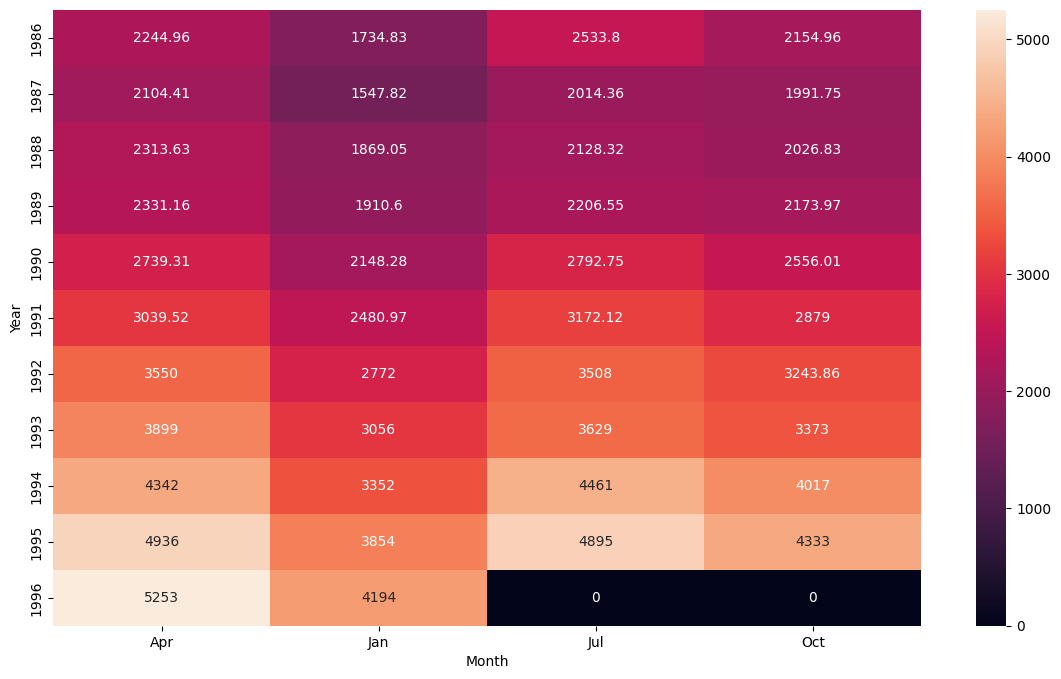

In [14]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="Year",columns="Month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

#### Histogram and Density Plots

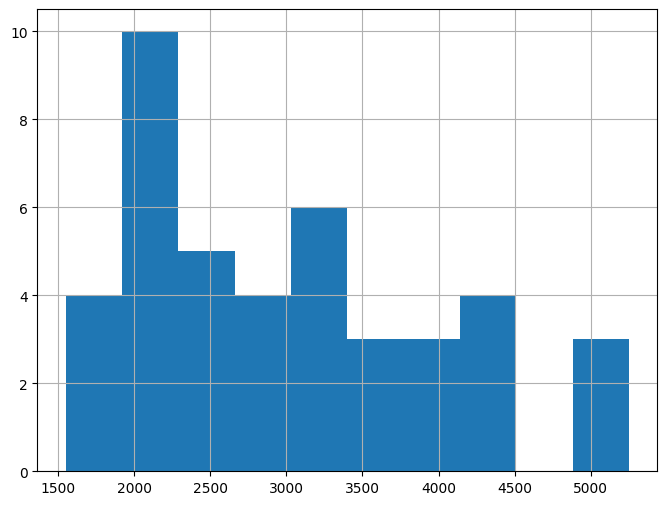

In [15]:
df['Sales'].hist(figsize=(8,6))
plt.show()

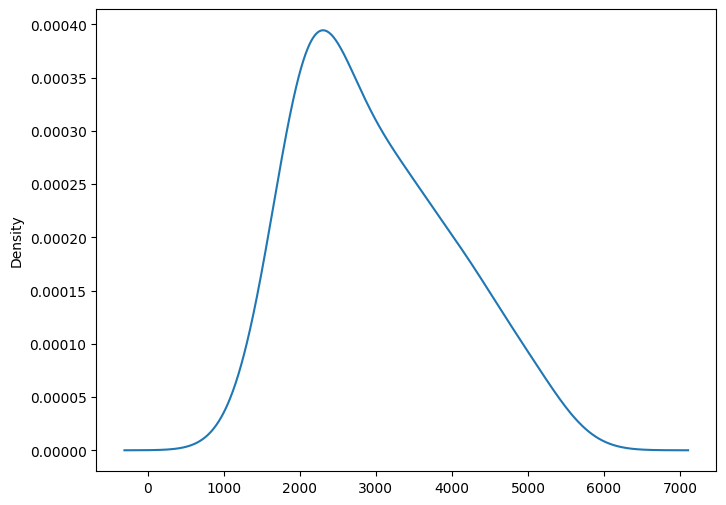

In [16]:
# create a density plot
df['Sales'].plot(kind='kde', figsize=(8,6))
plt.show()

#### Line plot

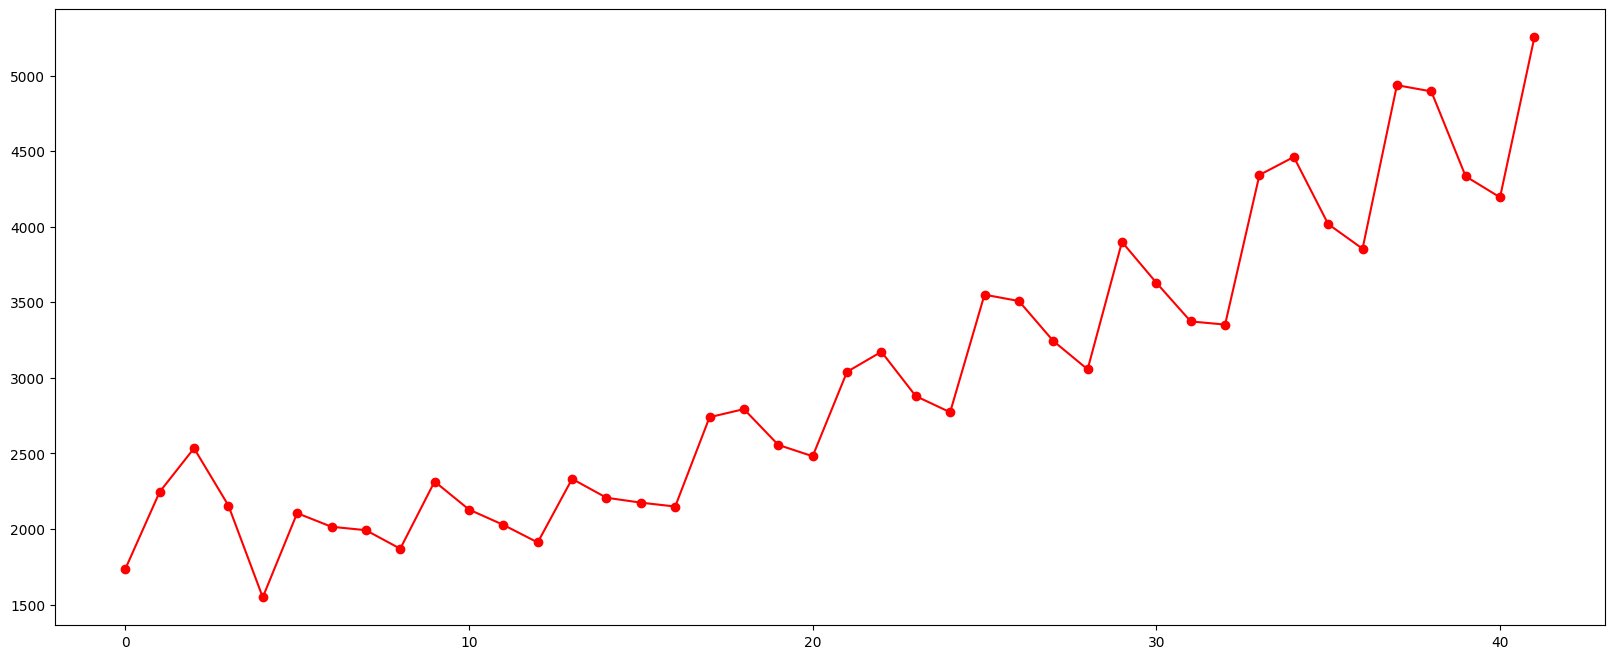

In [17]:
df['Sales'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

#### Box Plot of Each Year by Quaterly Intervals

<Axes: xlabel='Year', ylabel='Sales'>

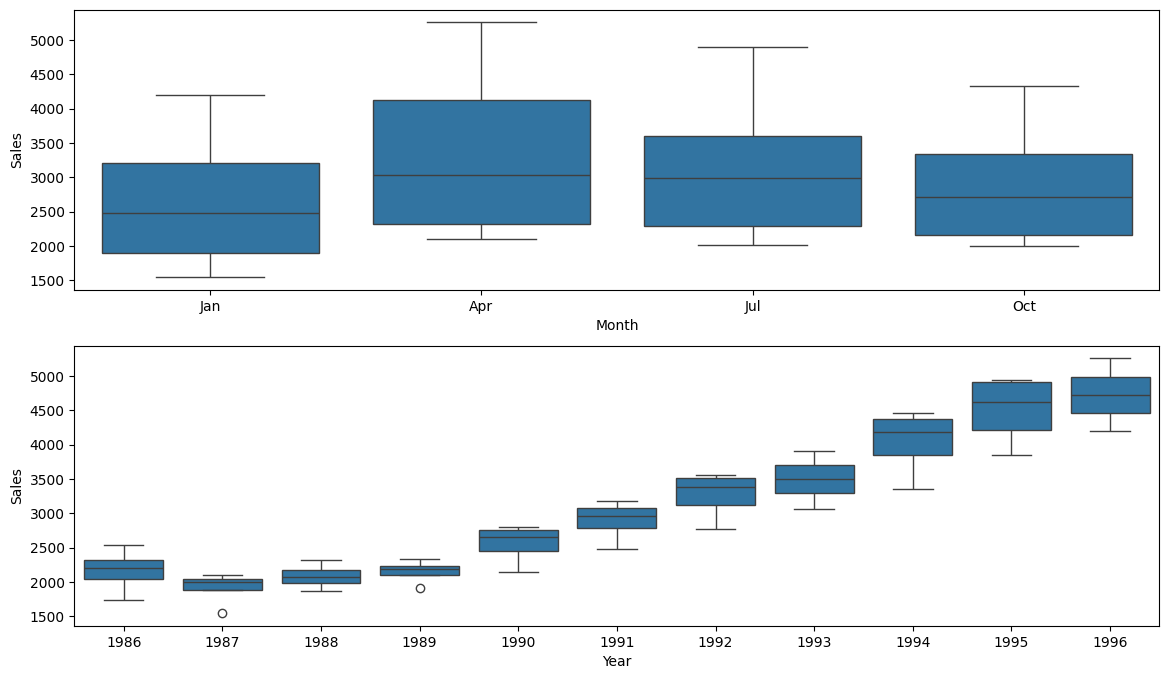

In [18]:
# Boxplot for ever
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="Month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="Year",y="Sales",data=df)

#### Line Plot Using Sales as Y axis and Quarters as X axis

<Axes: xlabel='Quarter', ylabel='Sales'>

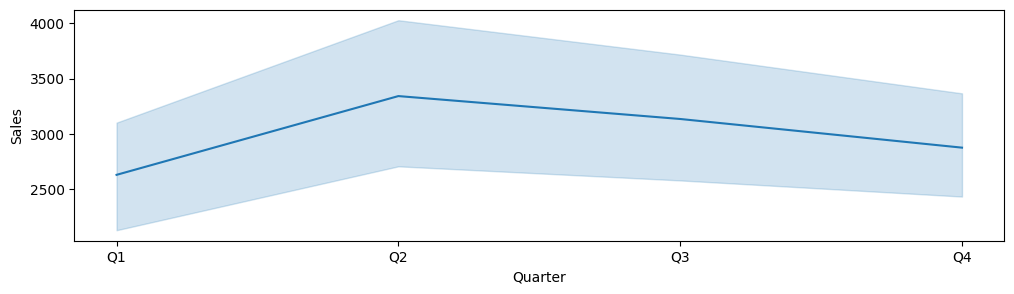

In [19]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Quarter", y="Sales", data=df)

#### Line Plot Using Sales as Y axis and Years as X axis

<Axes: xlabel='Year', ylabel='Sales'>

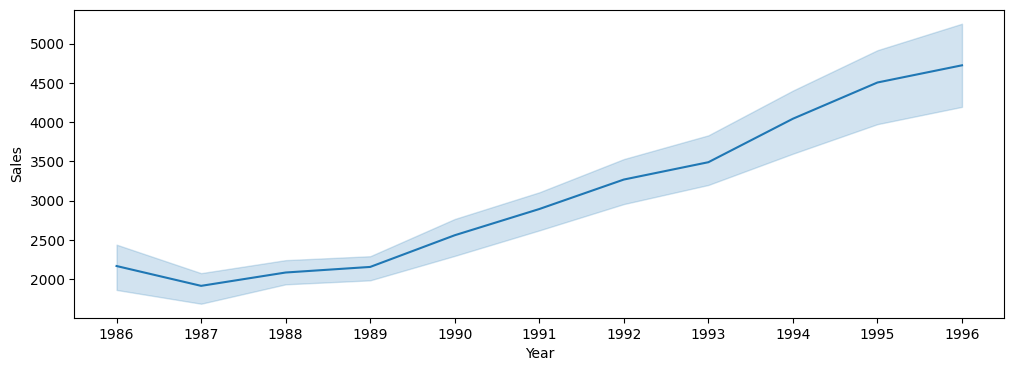

In [20]:
plt.figure(figsize=(12,4))
sns.lineplot(x="Year",y="Sales",data=df)

#### Lag plot

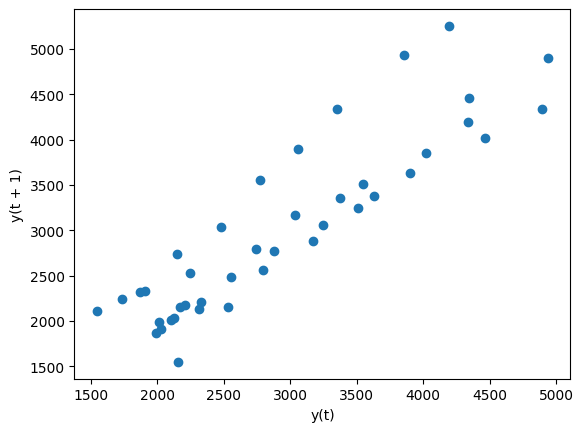

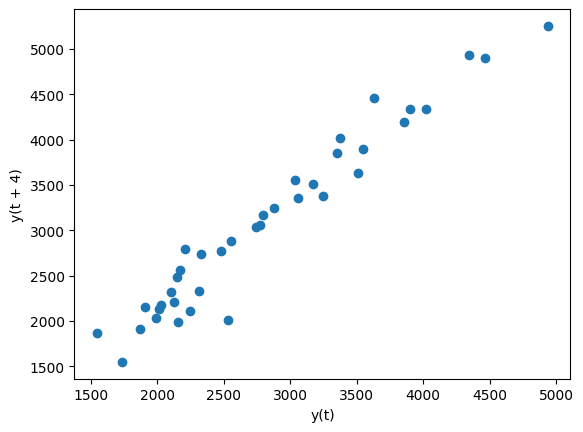

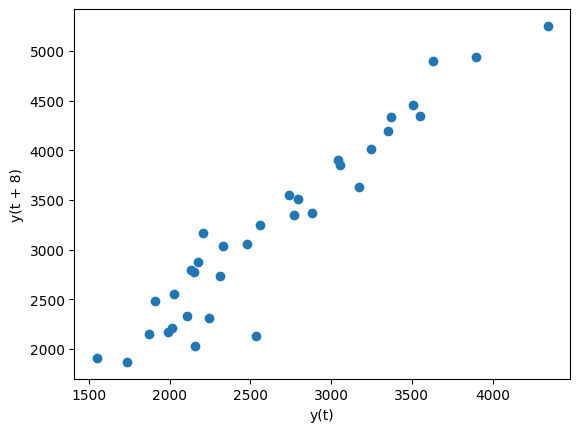

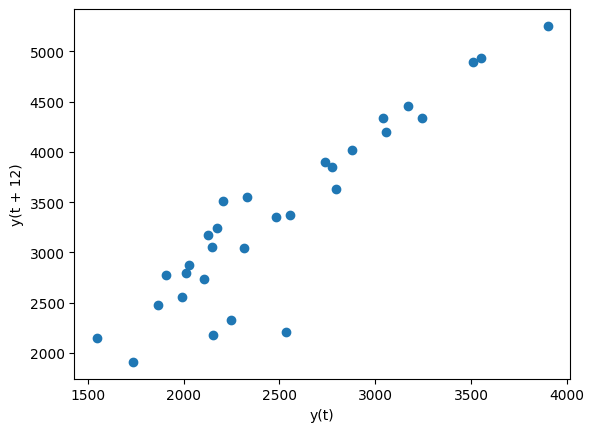

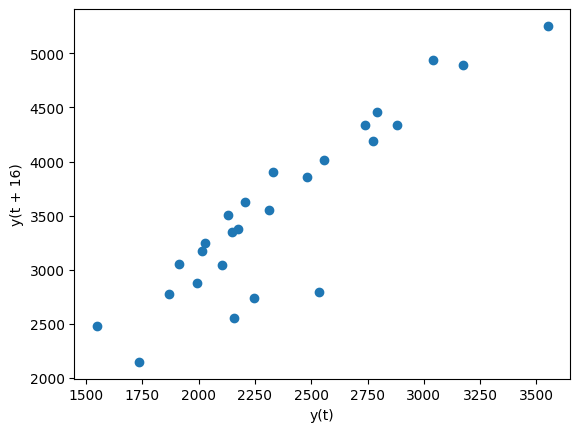

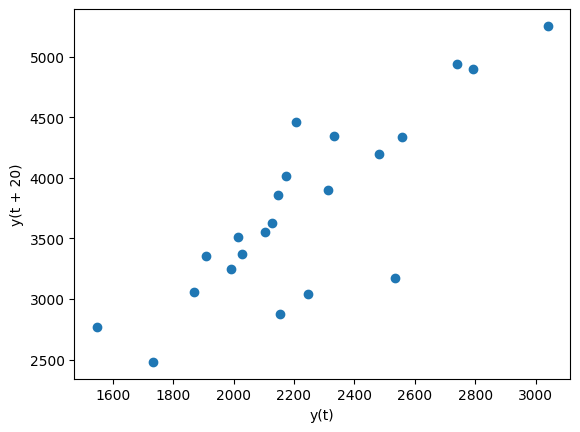

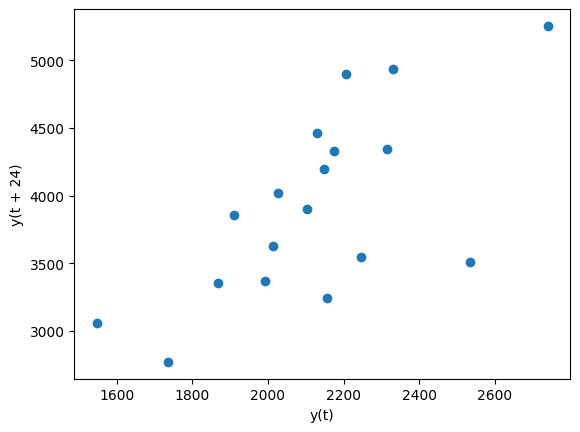

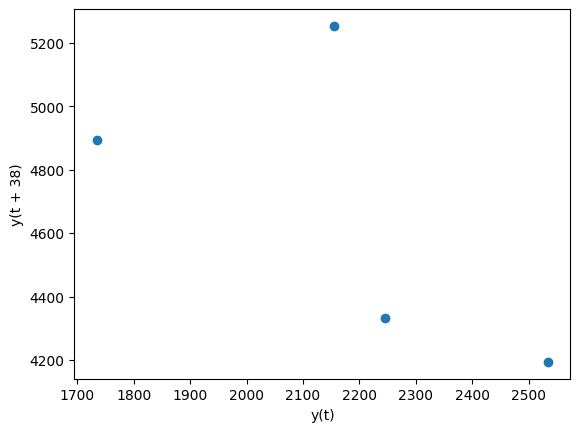

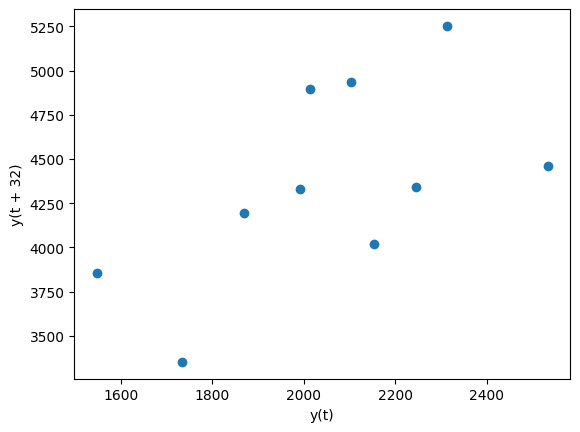

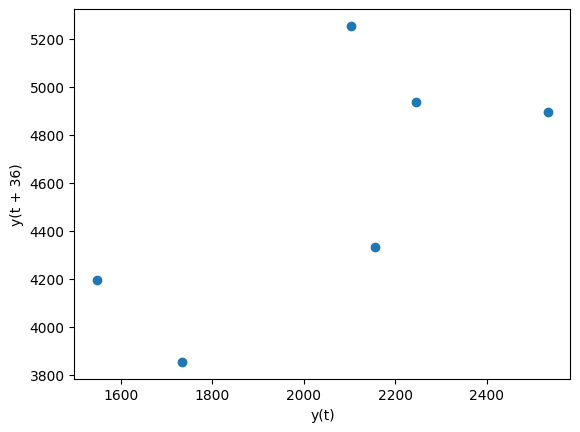

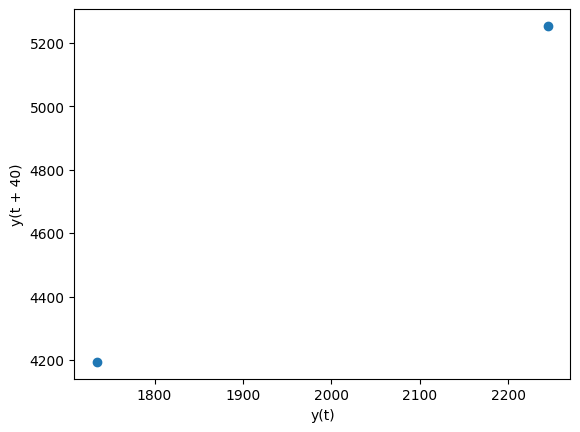

In [21]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Sales, lag=i)
    plt.show()

## Moving Average

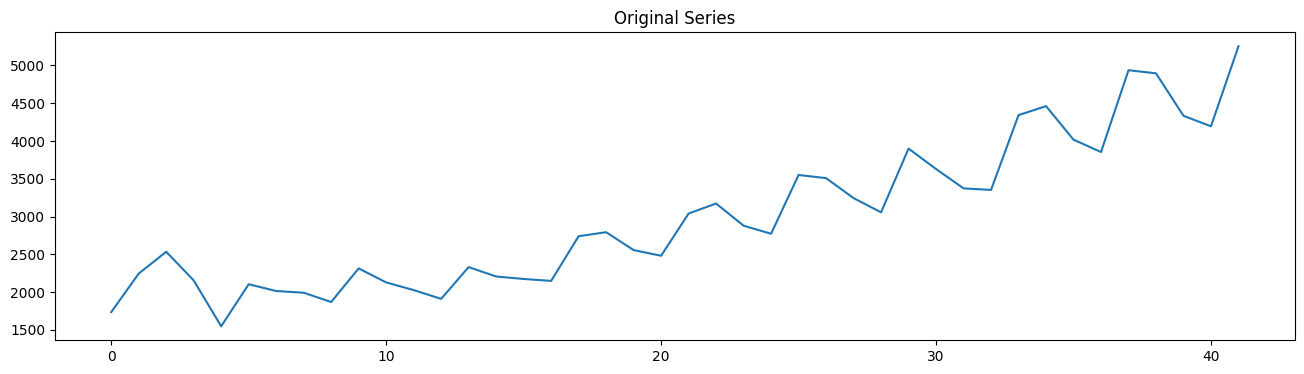

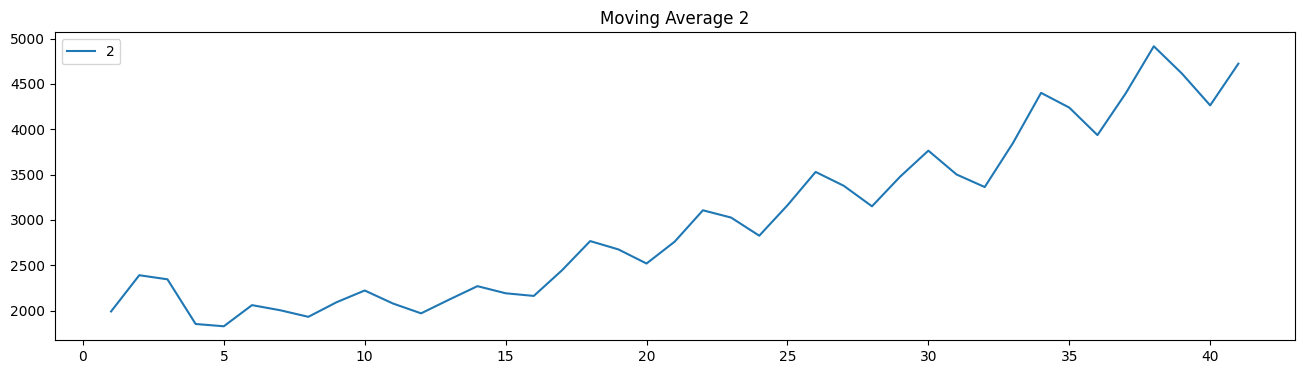

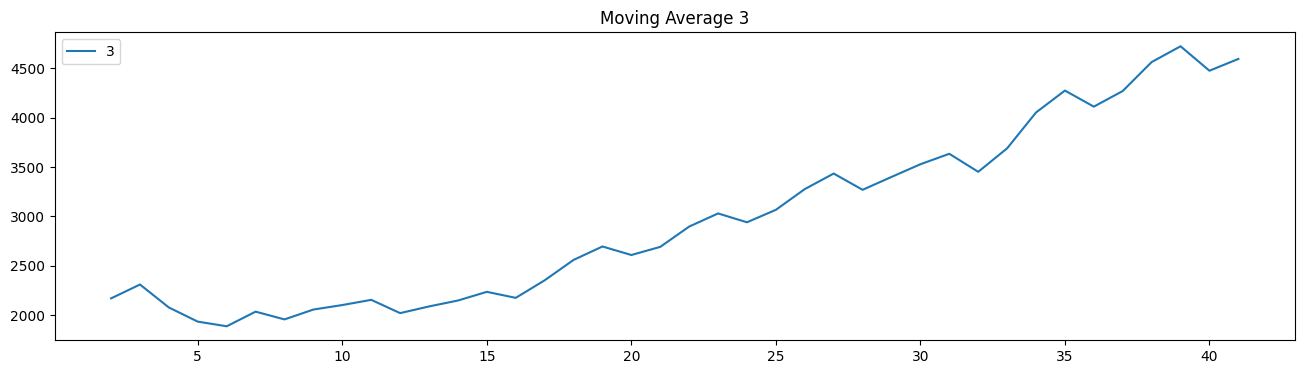

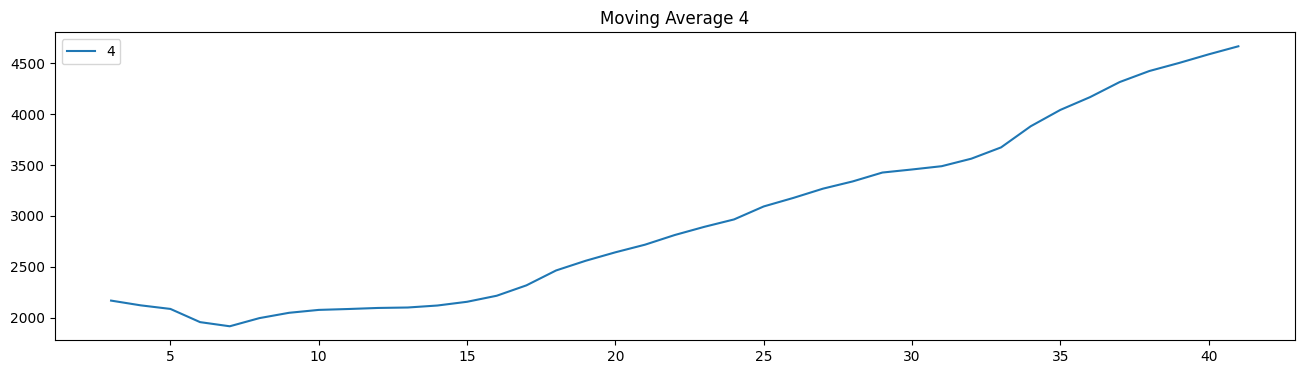

In [22]:
plt.figure(figsize=(16,4))
df.Sales.plot(label="org")
plt.title("Original Series")

for i in range(2,5):
    plt.figure(figsize=(16,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

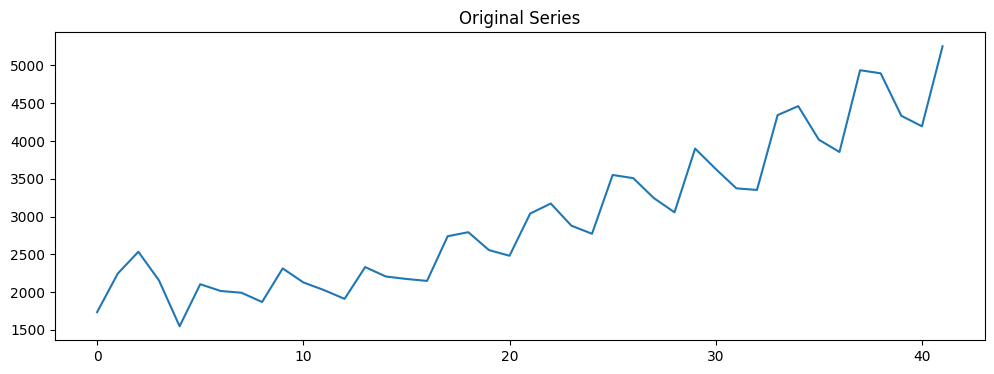

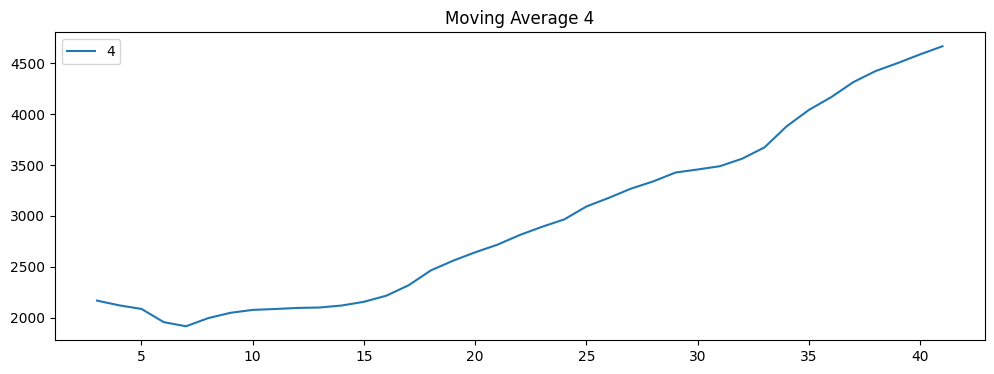

In [23]:
# Original Data
plt.figure(figsize=(12,4))
df.Sales.plot(label="org")
plt.title("Original Series")

# Moving Average 4
plt.figure(figsize=(12,4))
df["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

## ACF and PACF plots

## Time Series Decomposition plot

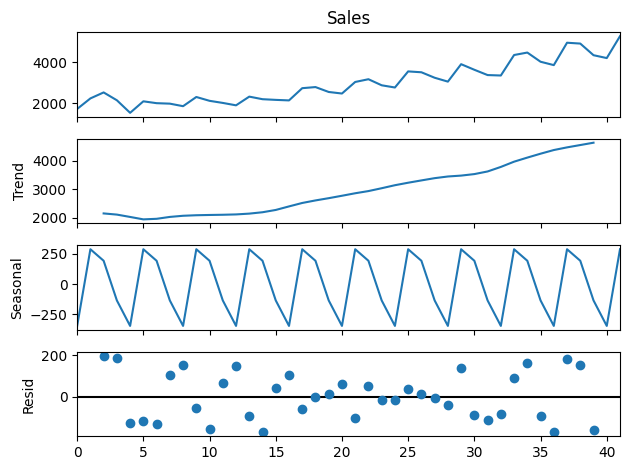

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(df['Sales'], period=4)
decompose_ts_add.plot()
plt.show()

## ACF and PACF plots

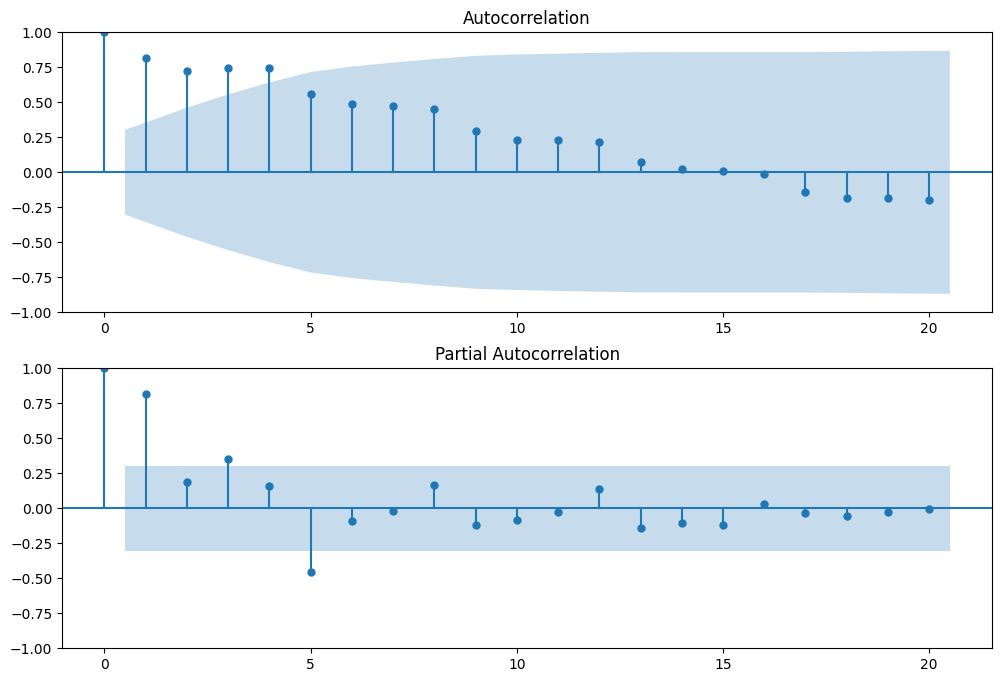

In [25]:
# Plot the ACF and PACF plots for the original time series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Sales'], lags=20, ax=ax[0])
plot_pacf(df['Sales'], lags=20, ax=ax[1])
plt.show()

## Upsampling & Linear Interpolation

In [26]:
df = df[['Date', 'Sales']]

df['Date'] = pd.to_datetime(df['Date'])

# Upsample the 'Date' column to months and interpolate the values
df = df.resample('M', on='Date').mean().interpolate()

# Display the upsampled data
df

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


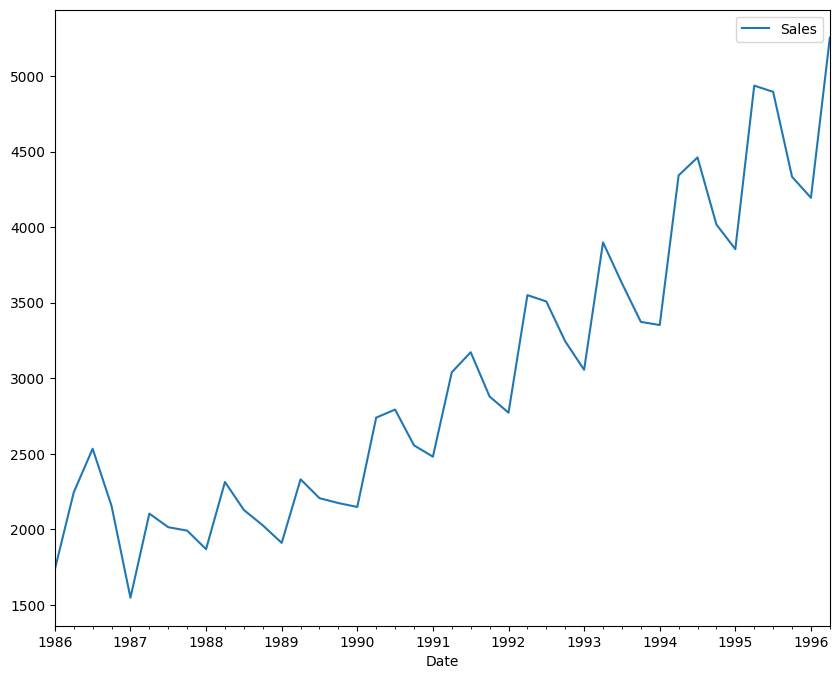

In [27]:
df.plot(figsize=(10,8))
plt.show()

## Moving Average

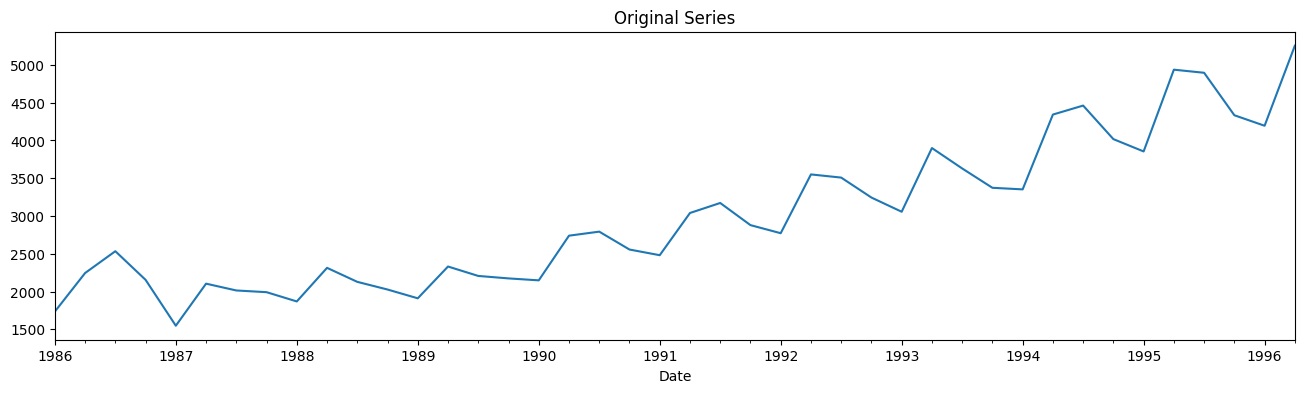

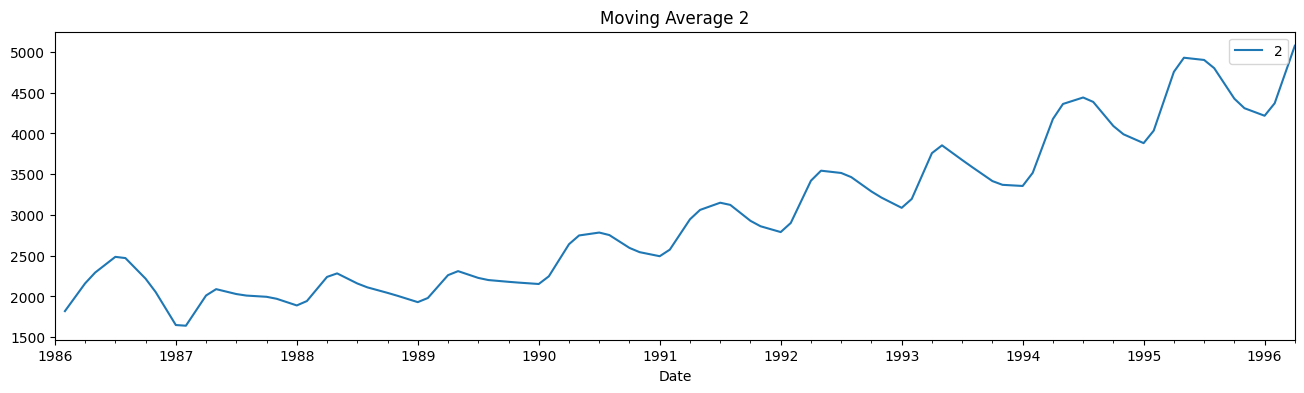

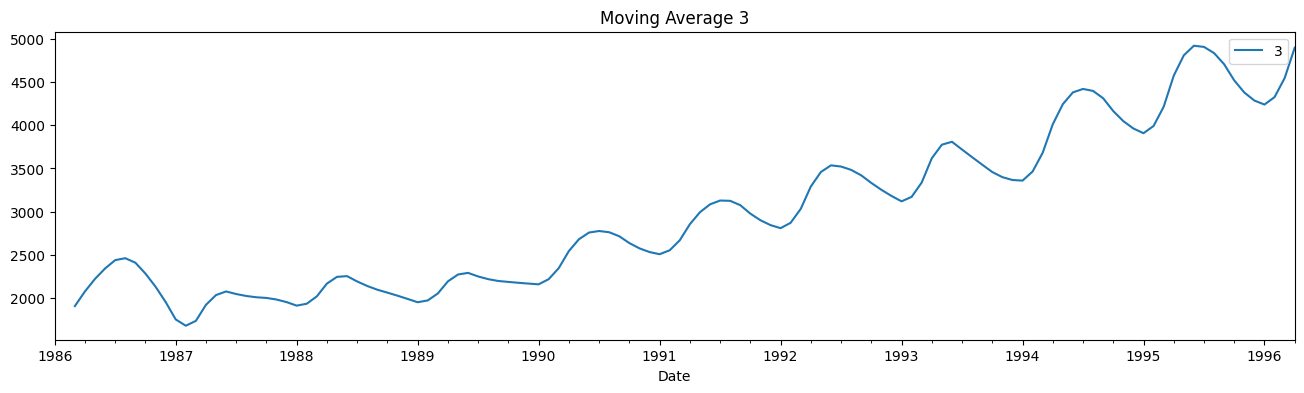

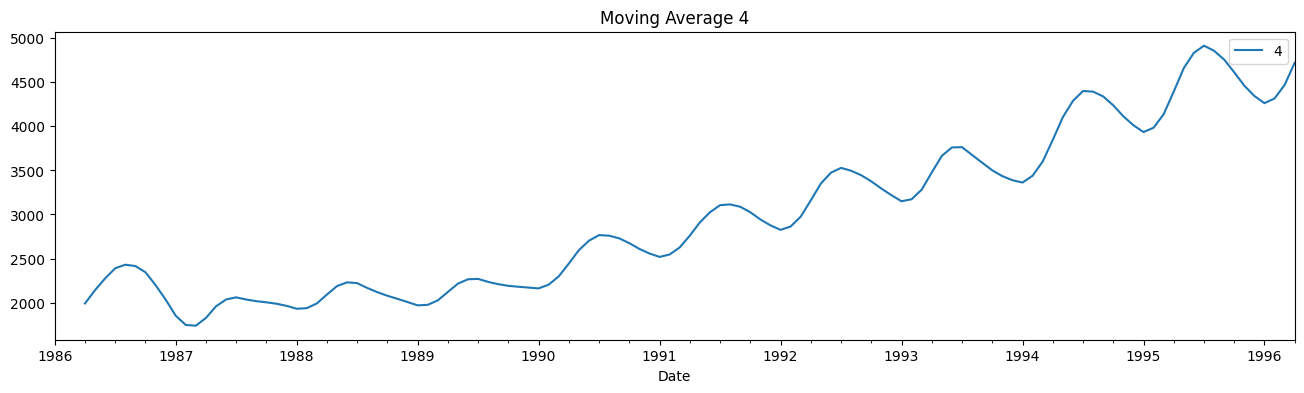

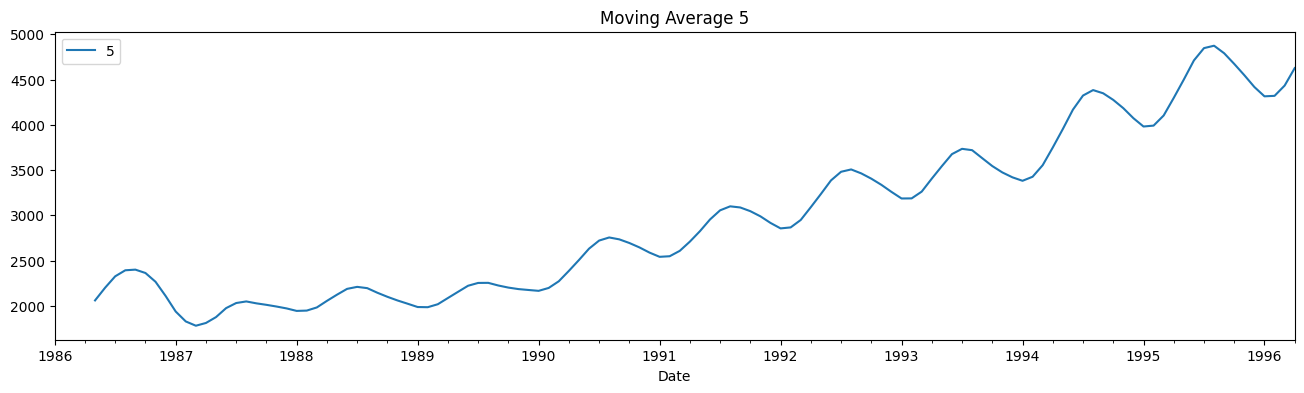

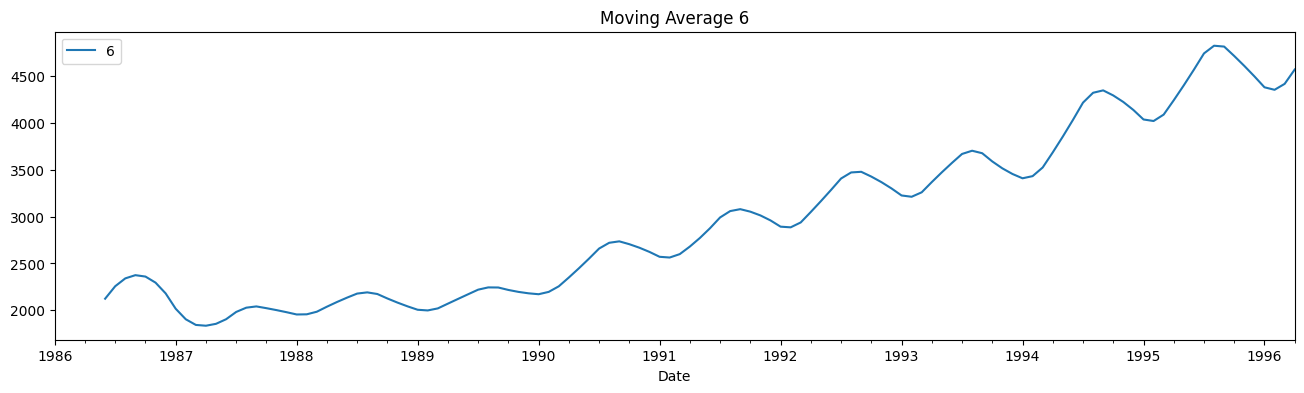

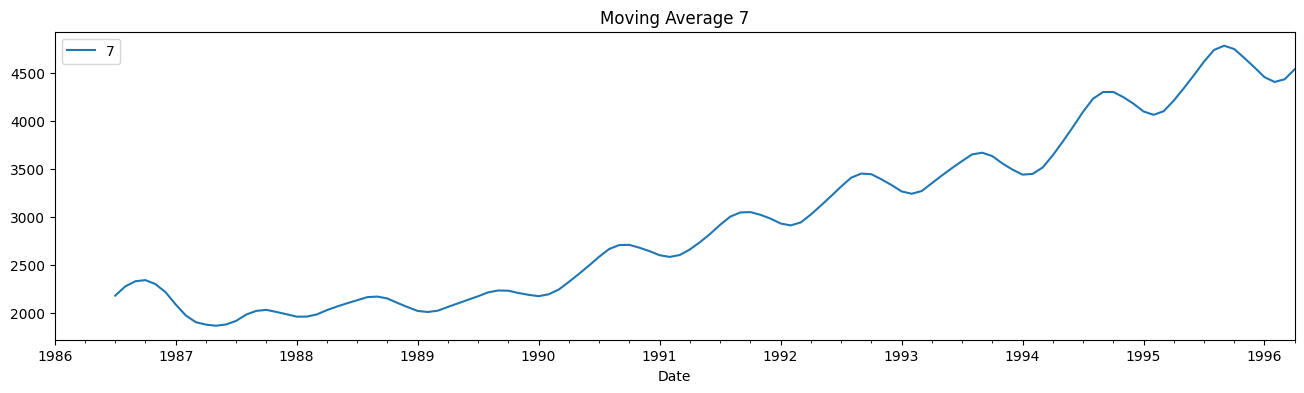

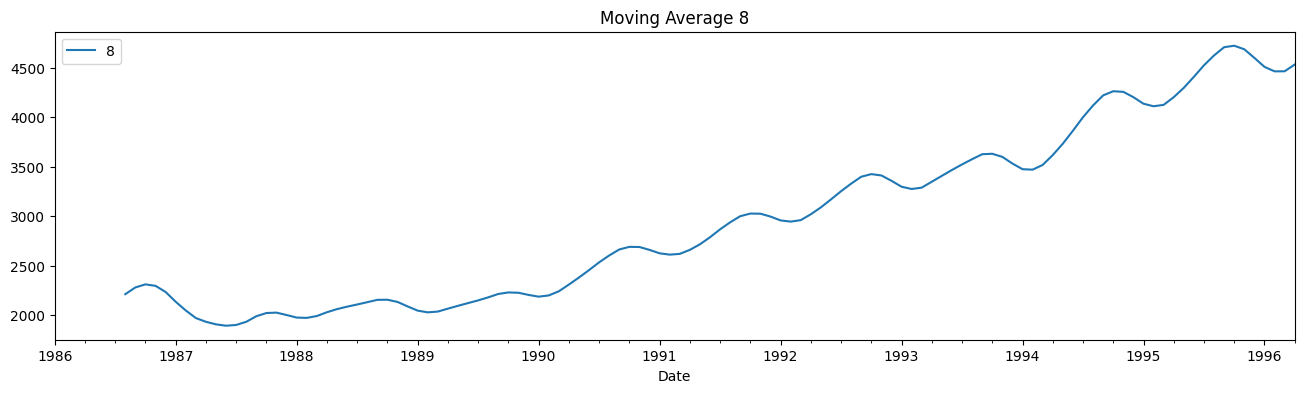

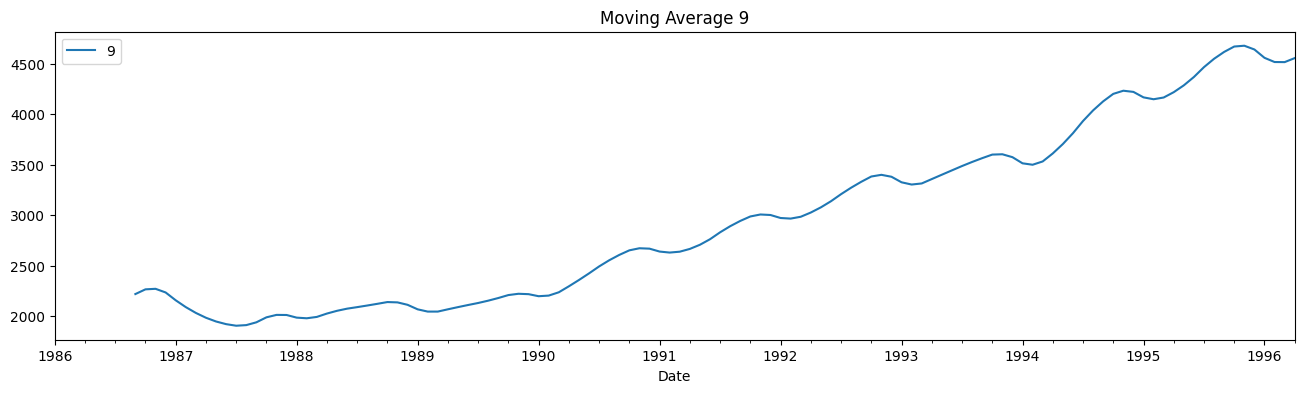

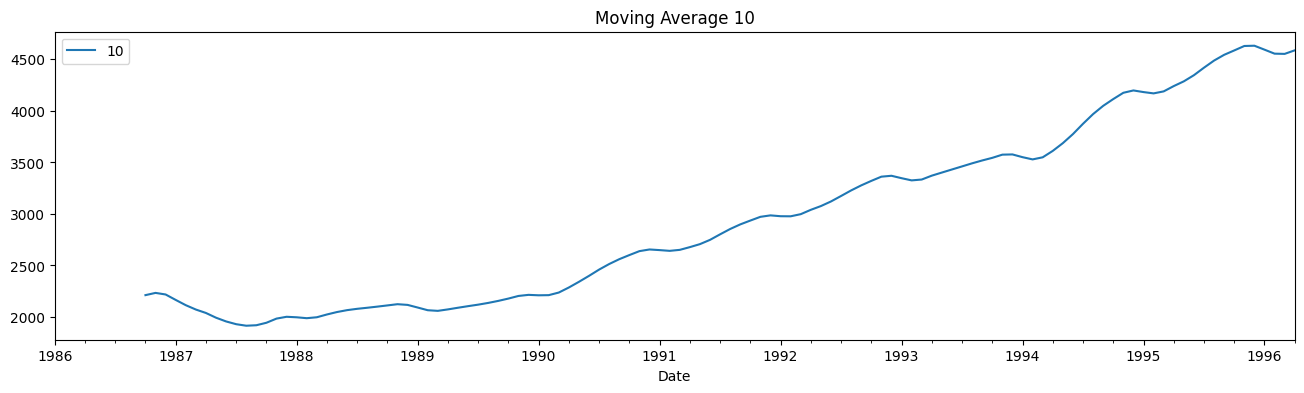

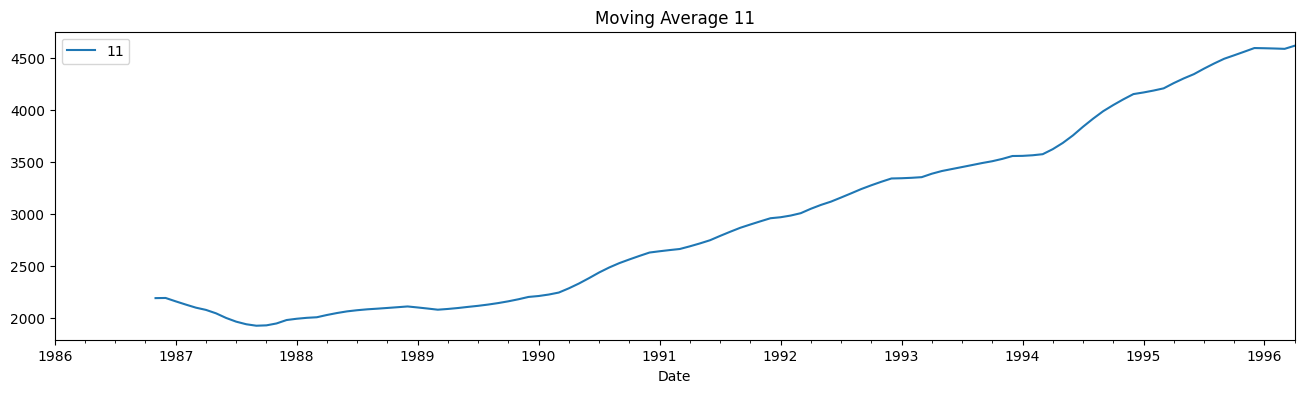

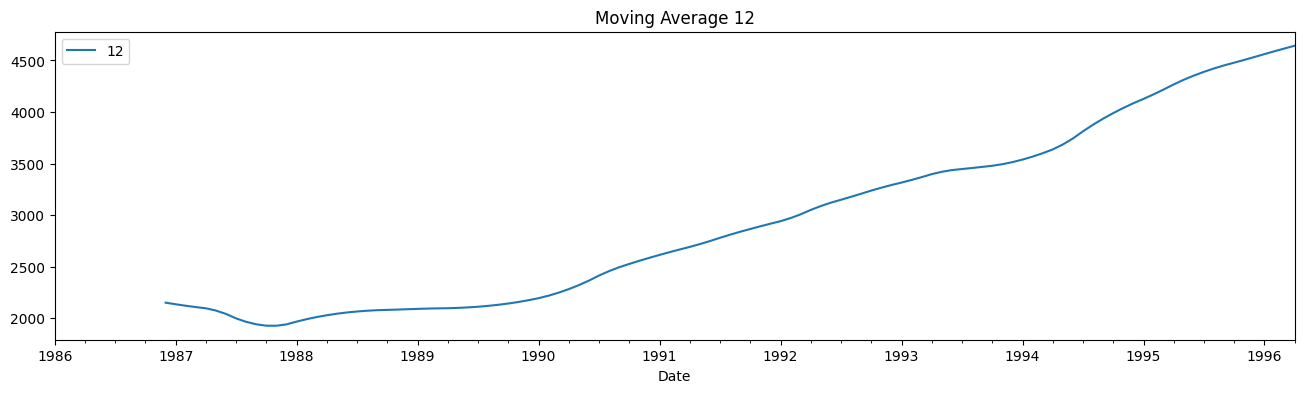

In [28]:
plt.figure(figsize=(16,4))
df['Sales'].plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

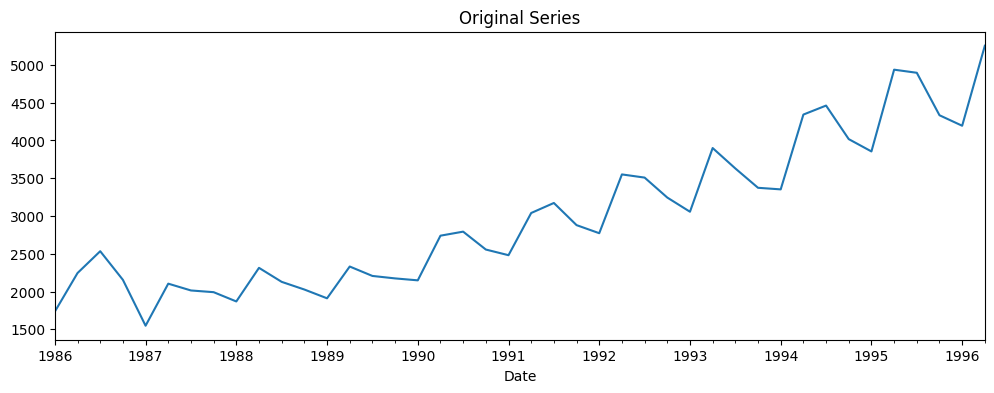

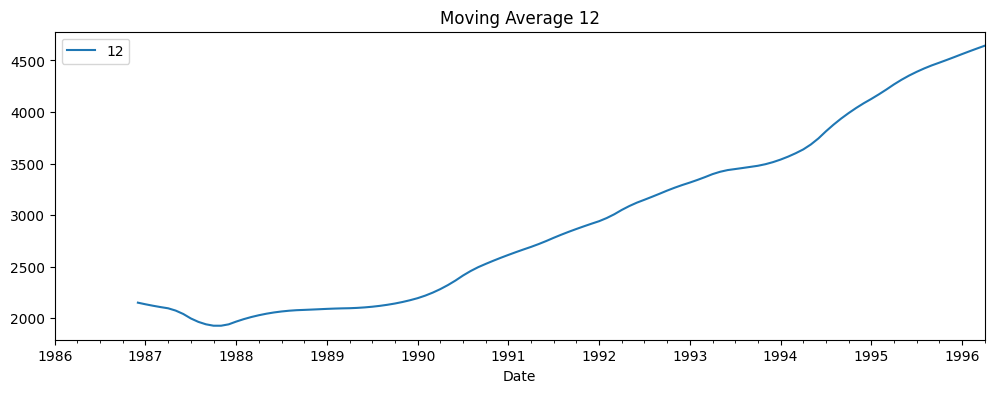

In [29]:
# Original Data
plt.figure(figsize=(12,4))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))

# Moving average 12
df["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

## Time Series Decomposition plot

### Additive Seasonal Decomposition

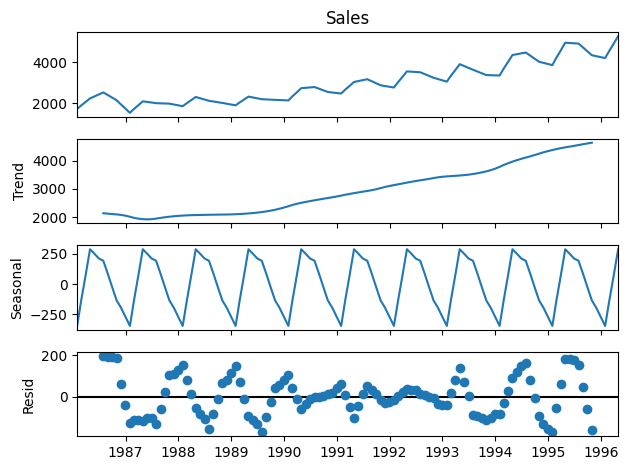

In [30]:
# Additive model
decompose_ts_add = seasonal_decompose(df['Sales'], model = 'additive', period=12) # Assuming monthly data, so period=12
decompose_ts_add.plot()
plt.show()

### Multiplicative Seasonal Decomposition

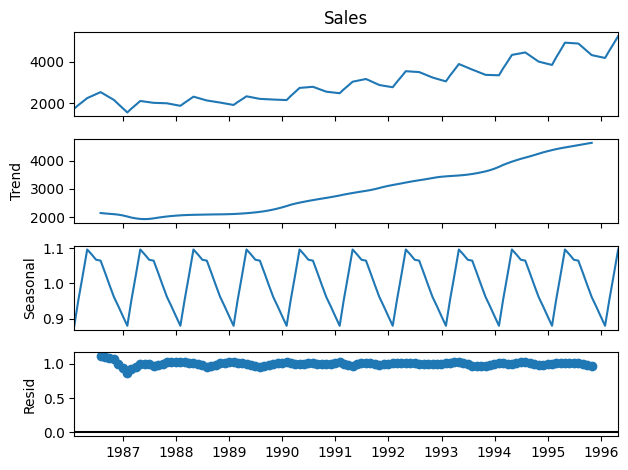

In [31]:
decompose_ts_mul = seasonal_decompose(df['Sales'], model = 'multiplicative', period=12) # Assuming monthly data, so period=12
decompose_ts_mul.plot()
plt.show()

### ACF and PACF plots for the upsampled time series data

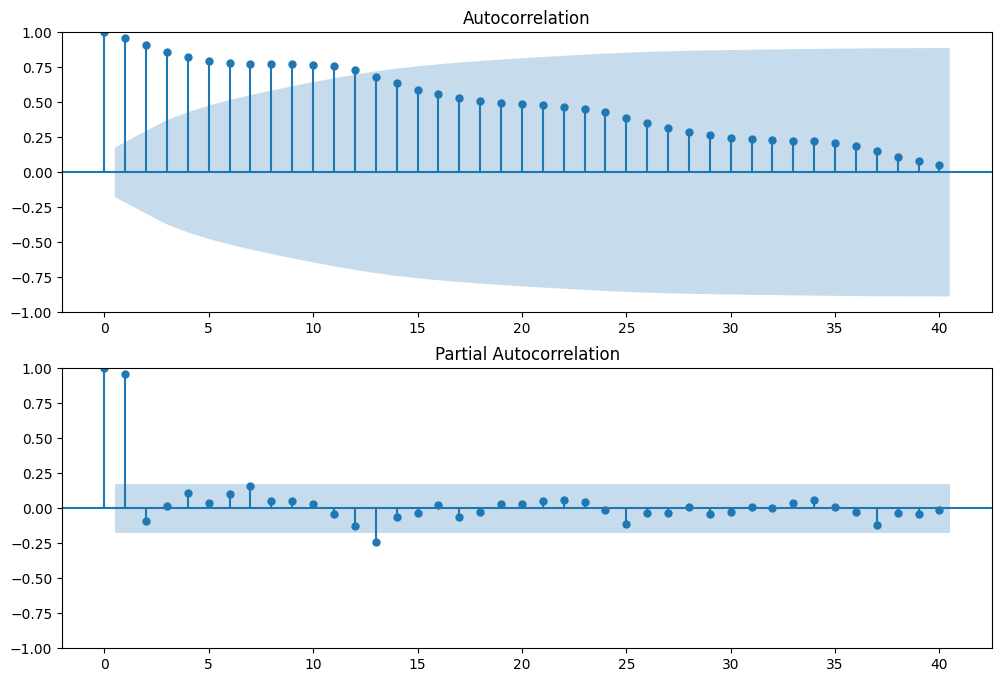

In [32]:
# Plot the ACF and PACF plots for the Upsampled time series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Sales'], lags=40, ax=ax[0])
plot_pacf(df['Sales'], lags=40, ax=ax[1])
plt.show()

## Data Partition

#### Utilizing the last 16 months for Testing purpose and preceding for the Training Purpose.



In [34]:
size = -16 #int(len(df)*0.8)

# Partition the data into train and test sets
Train = df.iloc[:size]
Test = df.iloc[size:]

In [35]:
# Print the lengths of train and test sets
print("Train set length:", len(Train))
print("Test set length:", len(Test))

Train set length: 108
Test set length: 16


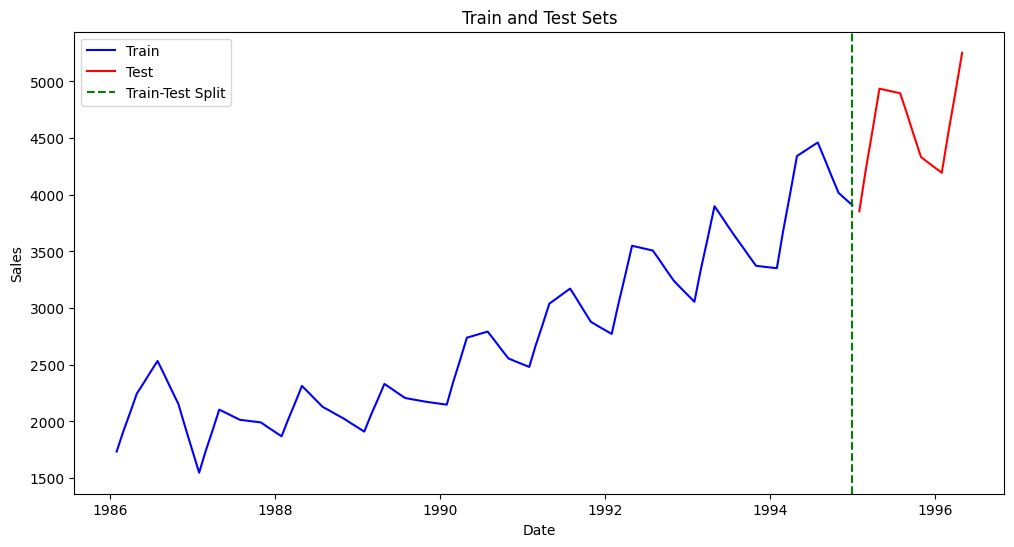

In [36]:
# Plotting train and test sets
plt.figure(figsize=(12, 6))
plt.plot(Train.index, Train['Sales'], label='Train', color = 'blue')
plt.plot(Test.index, Test['Sales'], label='Test', color = 'red')
plt.axvline(x=Train.index[-1], color='green', linestyle='--', label='Train-Test Split')
plt.title('Train and Test Sets')
plt.title('Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Building Forecasting Models

### Evaluation Metric MAPE

In [37]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Simple Exponential Method


##### Hyperparameter tuning

In [38]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Define a range of values for alpha
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create a list to store MAPE scores for different values of alpha
mape_scores = []

# Iterate over all values of alpha
for alpha in alphas:
    # Fit the model with current value of alpha
    ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=alpha)

    # Generate predictions
    pred_ses = ses_model.predict(start=Test.index[0], end=Test.index[-1])

    # Calculate MAPE using the provided function
    mape = MAPE(pred_ses, Test["Sales"])

    # Store the MAPE score and alpha value
    mape_scores.append((mape, alpha))

# Find the alpha value with the lowest MAPE
best_mape, best_alpha = min(mape_scores)

print("Best MAPE:", best_mape)
print("Best alpha:", best_alpha)

Best MAPE: 11.72877357790209
Best alpha: 0.3


In [39]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=best_alpha)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)

11.72877357790209

In [40]:
rmse_ses = np.sqrt(mean_squared_error(Test["Sales"], pred_ses))
print("Root Mean Squared Error (RMSE):", rmse_ses)

Root Mean Squared Error (RMSE): 645.7715381497223


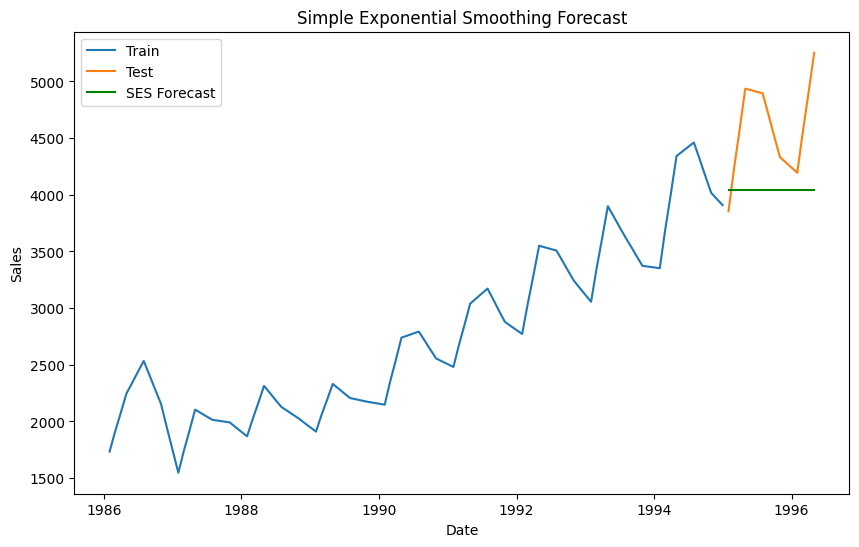

In [41]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Sales"], label='Train')
plt.plot(Test.index, Test["Sales"], label='Test')
plt.plot(Test.index, pred_ses, label='SES Forecast', color='green')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Holt method

##### Hyperparameter tuning

In [42]:
import numpy as np
from statsmodels.tsa.holtwinters import Holt
from itertools import product

# Define a range of values for smoothing_level and smoothing_slope
smoothing_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
smoothing_slopes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create a list to store MAPE scores for different combinations of parameters
mape_scores = []

# Iterate over all combinations of parameters
for smoothing_level, smoothing_slope in product(smoothing_levels, smoothing_slopes):
    # Fit the model with current parameter combination
    hw_model = Holt(Train["Sales"]).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    # Generate predictions
    pred_hw = hw_model.predict(start=Test.index[0], end=Test.index[-1])

    # Calculate MAPE using the provided function
    mape = MAPE(pred_hw, Test["Sales"])

    # Store the MAPE score and parameter combination
    mape_scores.append((mape, smoothing_level, smoothing_slope))

# Find the parameter combination with the lowest MAPE
best_mape, best_smoothing_level, best_smoothing_slope = min(mape_scores)

print("Best MAPE:", best_mape)
print("Best smoothing_level:", best_smoothing_level)
print("Best smoothing_slope:", best_smoothing_slope)

Best MAPE: 6.917173374215073
Best smoothing_level: 0.1
Best smoothing_slope: 0.8


In [43]:
# Holt method
hw_model = Holt(Train["Sales"]).fit(smoothing_level = best_smoothing_level,
                                    smoothing_slope = best_smoothing_slope)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
print('MAPE :',MAPE(pred_hw,Test.Sales))

MAPE : 6.917173374215073


In [44]:
rmse_hw_model = np.sqrt(mean_squared_error(Test["Sales"], pred_hw))
print("Root Mean Squared Error (RMSE):", rmse_hw_model)

Root Mean Squared Error (RMSE): 387.3122630030308


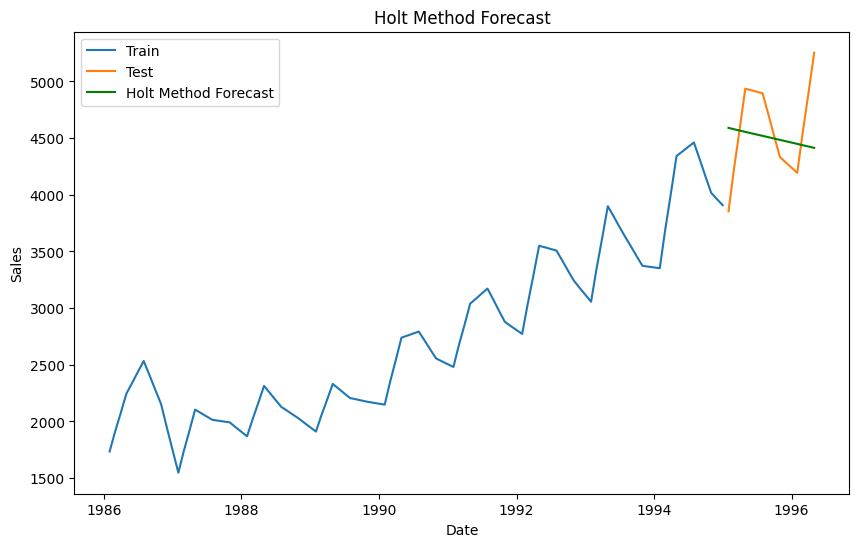

In [45]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Sales"], label='Train')
plt.plot(Test.index, Test["Sales"], label='Test')
plt.plot(Test.index, pred_hw, label='Holt Method Forecast', color='green')
plt.title('Holt Method Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Holts winter exponential smoothing with additive seasonality and additive trend

In [46]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
print('MAPE :', MAPE(pred_hwe_add_add,Test.Sales))

MAPE : 5.404589634214128


In [47]:
rmse_hwe_model_add_add = np.sqrt(mean_squared_error(Test["Sales"], pred_hwe_add_add))
print("Root Mean Squared Error (RMSE):", rmse_hwe_model_add_add)

Root Mean Squared Error (RMSE): 309.39419985549495


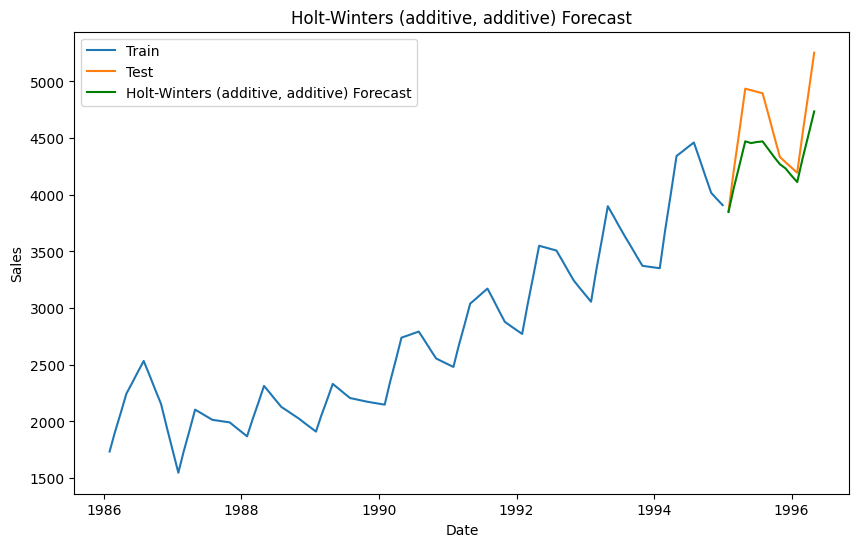

In [48]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Sales"], label='Train')
plt.plot(Test.index, Test["Sales"], label='Test')
plt.plot(Test.index, pred_hwe_add_add, label='Holt-Winters (additive, additive) Forecast', color='green')
plt.title('Holt-Winters (additive, additive) Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [49]:
min_value = Train["Sales"].min()

# Add a constant to shift all values to make them positive
Train["Sales_positive"] = Train["Sales"] - min_value + 1  # Add 1 to ensure all values are positive

# Fit Holt-Winters model using the preprocessed data
hwe_model_mul_add = ExponentialSmoothing(Train["Sales_positive"], seasonal="mul", trend="add", seasonal_periods=12).fit()
#hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

33.17994199103414

In [50]:
rmse_hwe_model_mul_add = np.sqrt(mean_squared_error(Test["Sales"], pred_hwe_mul_add))
print("Root Mean Squared Error (RMSE):", rmse_hwe_model_mul_add)

Root Mean Squared Error (RMSE): 1508.0277062180405


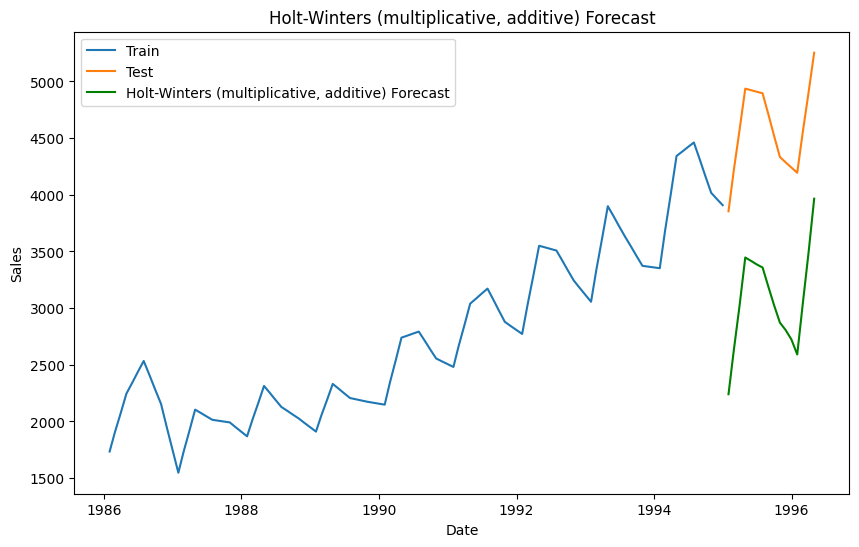

In [51]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Sales"], label='Train')
plt.plot(Test.index, Test["Sales"], label='Test')
plt.plot(Test.index, pred_hwe_mul_add, label='Holt-Winters (multiplicative, additive) Forecast', color='green')
plt.title('Holt-Winters (multiplicative, additive) Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## ARIMA

In [52]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Define the range of p, d, and q values
p_values = range(0, 5)  # AR order
d_values = range(0, 5)  # Differencing order
q_values = range(0, 5)  # MA order

# Generate all possible combinations of p, d, and q values
pdq = list(itertools.product(p_values, d_values, q_values))

best_aic = float("inf")
best_pdq = None

# Iterate over all combinations and select the one with the lowest AIC
for params in pdq:
    try:
        model = ARIMA(Train['Sales'], order=params)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_pdq = params
    except:
        continue

#Fit the best ARIMA model
best_model = ARIMA(Train['Sales'], order=best_pdq)
best_results = best_model.fit()

#Print the best model summary
best_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  108
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -602.789
Date:                Thu, 02 May 2024   AIC                           1221.578
Time:                        19:09:42   BIC                           1242.961
Sample:                    01-31-1986   HQIC                          1230.246
                         - 12-31-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4454      0.241      6.005      0.000       0.974       1.917
ar.L2         -0.5118      0.417     -1.227      0.220      -1.330       0.306
ar.L3         -0.2824      0.242     -1.166      0.243      -0.757       0.192
ma.L1         -0.6795      0.575     -1.181      0.238      -1.807       0.448
ma.L2          0.1802      0.139      1.294      0.196      -0.093       0.453
ma.L3         -0.6853      0.643     -1.065      0.287      -1.946       0.576
ma.L4          0.9944      0.170      5.852      0.000       0.661       1.327
sigma2      4213.4905      0.000   1.66e+07      0.000    4213.490    4213.491
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                64.52
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.91
Prob(H) (two-sided):                  0.11   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  6e+22. Standard errors may be unstable.
"""

In [53]:
best_order = best_pdq
print('Order :',best_order)

Order : (3, 1, 4)


In [54]:
# Build the ARIMA(2, 0, 4) model
model = ARIMA(Train['Sales'], order = best_order)
arima_result = model.fit()

# Print the model summary
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  108
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -602.789
Date:                Thu, 02 May 2024   AIC                           1221.578
Time:                        19:09:43   BIC                           1242.961
Sample:                    01-31-1986   HQIC                          1230.246
                         - 12-31-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4454      0.241      6.005      0.000       0.974       1.917
ar.L2         -0.5118      0.417     -1.227      0.220      -1.330       0.306
ar.L3         -0.2824      0.242     -1.166      0.243      -0.757       0.192
ma.L1         -0.6795      0.575     -1.181      0.238      -1.807       0.448
ma.L2          0.1802      0.139      1.294      0.196      -0.093       0.453
ma.L3         -0.6853      0.643     -1.065      0.287      -1.946       0.576
ma.L4          0.9944      0.170      5.852      0.000       0.661       1.327
sigma2      4213.4905      0.000   1.66e+07      0.000    4213.490    4213.491
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                64.52
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.91
Prob(H) (two-sided):                  0.11   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  6e+22. Standard errors may be unstable.
"""

In [55]:
start = len(Train)
end = start + len(Test) - 1

# Forecast the test data
arima_predictions = arima_result.predict(start=start, end=end, typ='levels')

# Print the forecast
arima_predictions

1995-01-31    3893.401223
1995-02-28    3998.829200
1995-03-31    4132.253956
1995-04-30    4235.260805
1995-05-31    4286.082087
1995-06-30    4269.137889
1995-07-31    4189.546771
1995-08-31    4068.828253
1995-09-30    3939.866087
1995-10-31    3837.730022
1995-11-30    3790.201338
1995-12-31    3810.198661
1996-01-31    3892.271563
1996-02-29    4014.084709
1996-03-31    4142.496600
1996-04-30    4242.576203
Freq: M, Name: predicted_mean, dtype: float64

In [56]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate mean squared error
print('MSE :',mean_squared_error(Test["Sales"], arima_predictions))

# Calculate root mean squared error
rmse_arima = rmse(Test["Sales"], arima_predictions)
print('RMSE :', rmse_arima)

MSE : 339913.69657357445
RMSE : 583.021180210097


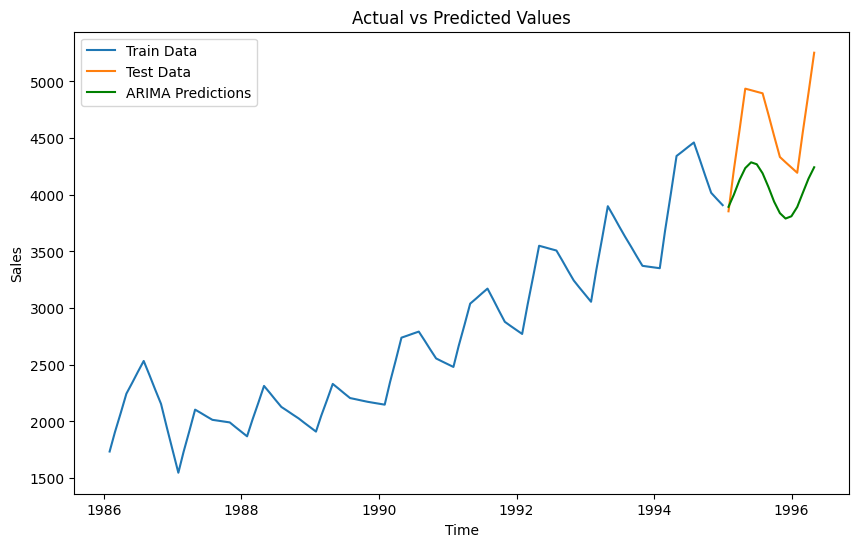

In [57]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train['Sales'], label='Train Data')
plt.plot(Test.index, Test['Sales'], label='Test Data')
plt.plot(arima_predictions.index, arima_predictions, color='green', label='ARIMA Predictions')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Auto ARIMA Model Training

In [123]:
stepwise_fit = auto_arima(Train['Sales'], start_p = 1, start_q = 1,
                          max_p = 5, max_q = 5, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore', # we don't want to know if an order does not work
                          suppress_warnings = True, # we don't want convergence warnings
                          stepwise = True)     # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1002.934, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1052.679, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1003.418, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1017.419, Time=0.27 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1001.377, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1003.257, Time=0.20 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1005.297, Time=0.58 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1016.487, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1001.519, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=996.730, Time=0.21 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=998.388, Time=0.61 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=997.659, Time=0.66 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=999.415, Time=0.16 sec
 ARIMA(3,1,1)(0,1,0)[12]    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(5, 1, 1)x(0, 1, [], 12)   Log Likelihood                -488.762
Date:                             Thu, 02 May 2024   AIC                            991.524
Time:                                     19:16:13   BIC                           1009.401
Sample:                                          0   HQIC                           998.748
                                             - 108                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6129      0.286      5.642      0.000       1.053       2.173
ar.L2         -0.6872      0.382     -1.801      0.072      -1.435       0.061
ar.L3         -0.4093      0.316     -1.297      0.195      -1.028       0.209
ar.L4          0.6520      0.165      3.949      0.000       0.328       0.976
ar.L5         -0.3141      0.108     -2.909      0.004      -0.526      -0.102
ma.L1         -0.8495      0.255     -3.329      0.001      -1.350      -0.349
sigma2      1698.9331    171.206      9.923      0.000    1363.376    2034.490
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                67.84
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.00
Prob(H) (two-sided):                  0.12   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

In [125]:
print('Order :', best_order)
print('Seasonal Order :', best_seasonal_order)

Order : (5, 1, 1)
Seasonal Order : (0, 1, 0, 12)


## SARIMA

In [126]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model using the provided specifications
sarimax_model = SARIMAX(Train['Sales'],
                        order = best_order,
                        seasonal_order = best_seasonal_order)

# Fit the SARIMAX model to the training data
sarimax_result = sarimax_model.fit()

# Print the summary of the fitted SARIMAX model
sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                  108
Model:             SARIMAX(5, 1, 1)x(0, 1, [], 12)   Log Likelihood                -488.762
Date:                             Thu, 02 May 2024   AIC                            991.524
Time:                                     19:16:13   BIC                           1009.401
Sample:                                          0   HQIC                           998.748
                                             - 108                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6129      0.286      5.642      0.000       1.053       2.173
ar.L2         -0.6872      0.382     -1.801      0.072      -1.435       0.061
ar.L3         -0.4093      0.316     -1.297      0.195      -1.028       0.209
ar.L4          0.6520      0.165      3.949      0.000       0.328       0.976
ar.L5         -0.3141      0.108     -2.909      0.004      -0.526      -0.102
ma.L1         -0.8495      0.255     -3.329      0.001      -1.350      -0.349
sigma2      1698.9331    171.206      9.923      0.000    1363.376    2034.490
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                67.84
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.00
Prob(H) (two-sided):                  0.12   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [127]:
# Forecast
start = len(Train)
end = start + len(Test) - 1

# Generate predictions
sarima_predictions = sarimax_result.predict(start = start,
                             end = end,
                             dynamic=False)

# Print the predictions
sarima_predictions.head()

108    3852.768489
109    4135.172012
110    4429.980446
111    4739.818023
112    4773.838238
Name: predicted_mean, dtype: float64

In [128]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate mean squared error
print('MSE :',mean_squared_error(Test["Sales"], sarima_predictions))

# Calculate root mean squared error
rmse_sarima = rmse(Test["Sales"], sarima_predictions)
print('RMSE :', rmse_sarima)

MSE : 12262.037771144769
RMSE : 110.73408585952552


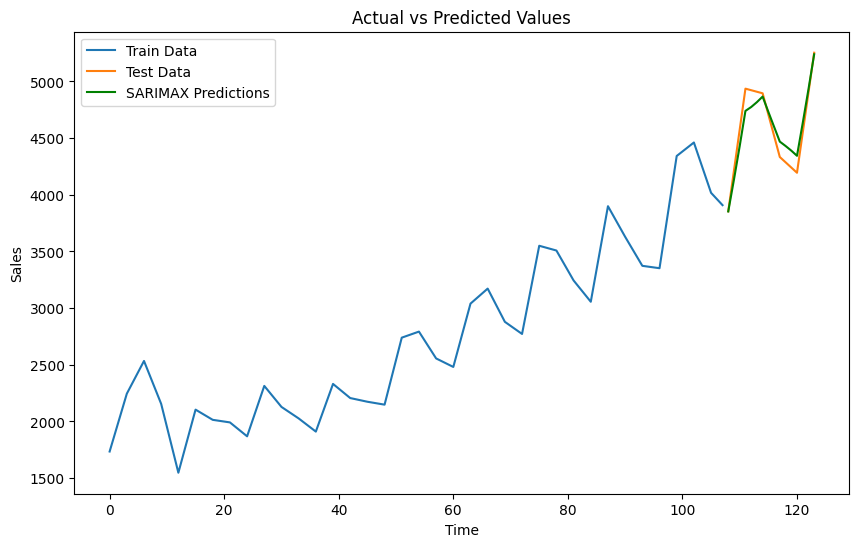

In [129]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train['Sales'], label='Train Data')
plt.plot(Test.index, Test['Sales'], label='Test Data')
plt.plot(sarima_predictions.index, sarima_predictions, color='green', label='SARIMAX Predictions')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [130]:
#Compare the results
data1 = {"MODEL":pd.Series(["SES", "Holt", 'hwe_model_add_add', 'hwe_model_mul_add', 'ARIMA', 'SARIMA']),
        "RMSE_Values":pd.Series([rmse_ses, rmse_hw_model, rmse_hwe_model_add_add, rmse_hwe_model_mul_add, rmse_arima, rmse_sarima])}
type(data1)

table_rmse1=pd.DataFrame(data1)
table_rmse1.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
5,SARIMA,110.734086
2,hwe_model_add_add,309.394200
1,Holt,387.312263
4,ARIMA,583.021180
0,SES,645.771538
3,hwe_model_mul_add,1508.027706


## Visualizing Models Performance

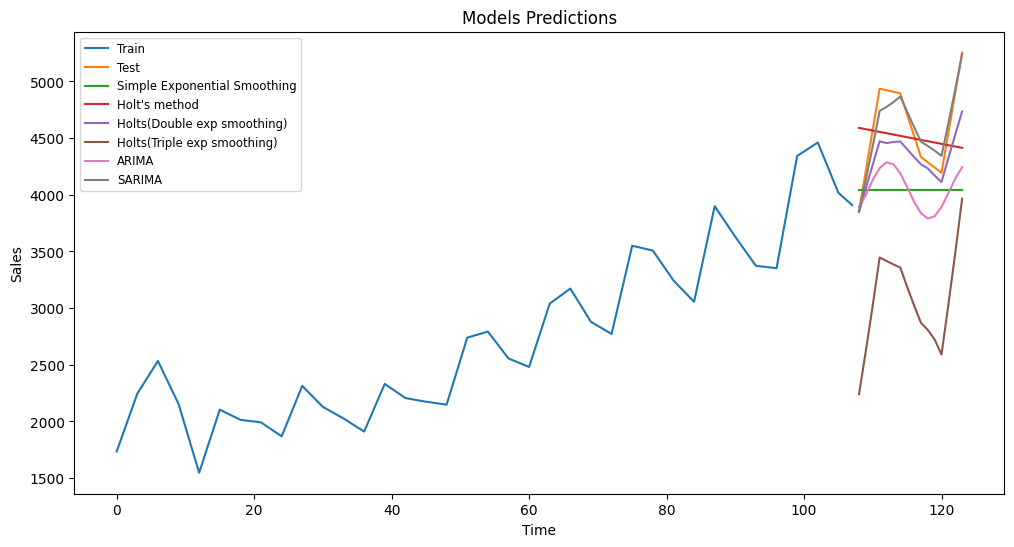

In [168]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(Train['Sales'], label='Train')
plt.plot(Test.index, Test['Sales'], label='Test')

# Plot predicted data
plt.plot(Test.index, pred_ses, label='Simple Exponential Smoothing')
plt.plot(Test.index, pred_hw, label="Holt's method")
plt.plot(Test.index, pred_hwe_add_add, label='Holts(Double exp smoothing)')
plt.plot(Test.index, pred_hwe_mul_add, label='Holts(Triple exp smoothing)')
plt.plot(Test.index, arima_predictions, label='ARIMA')
plt.plot(Test.index, sarima_predictions, label='SARIMA')

plt.title('Models Predictions')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc = 'best', fontsize='small')
plt.show()

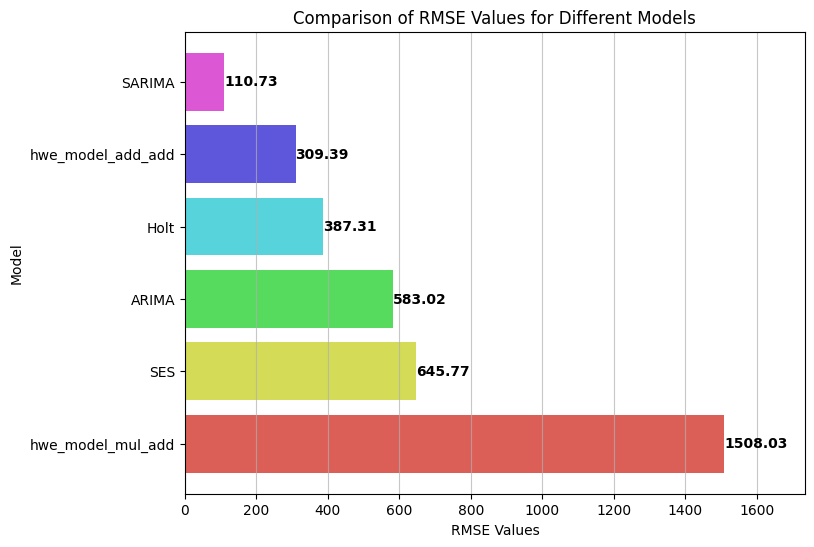

In [131]:
# Sort DataFrame by RMSE values in ascending order
table_rmse1 = table_rmse1.sort_values(by='RMSE_Values', ascending=False)

# Create a color palette using seaborn's 'hls' palette
colors = sns.color_palette('hls', len(table_rmse1))

# Create visualization with the 'hls' palette
plt.figure(figsize=(8, 6))
bars = plt.barh(table_rmse1['MODEL'], table_rmse1['RMSE_Values'], color=colors)
plt.xlabel('RMSE Values')
plt.ylabel('Model')
plt.title('Comparison of RMSE Values for Different Models')
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Add RMSE values next to the bars
for bar, value in zip(bars, table_rmse1['RMSE_Values']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', fontweight='bold')

# Adjust x-axis limits to accommodate annotations
plt.xlim(0, max(table_rmse1['RMSE_Values']) * 1.15)

plt.show()


## Best Model

In [132]:
# Training the model on the entire data
sarimax_model = SARIMAX(df['Sales'],
                        order = best_order,
                        seasonal_order = best_seasonal_order)

# Fit the SARIMAX model to the training data
sarimax_result = sarimax_model.fit()

# Print the summary of the fitted SARIMAX model
sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                  124
Model:             SARIMAX(5, 1, 1)x(0, 1, [], 12)   Log Likelihood                -566.250
Date:                             Thu, 02 May 2024   AIC                           1146.501
Time:                                     19:16:15   BIC                           1165.467
Sample:                                 01-31-1986   HQIC                          1154.195
                                      - 04-30-1996                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1755      0.443      2.651      0.008       0.307       2.044
ar.L2         -0.3631      0.419     -0.867      0.386      -1.184       0.458
ar.L3         -0.3982      0.212     -1.878      0.060      -0.814       0.017
ar.L4          0.4982      0.168      2.968      0.003       0.169       0.827
ar.L5         -0.2788      0.160     -1.747      0.081      -0.592       0.034
ma.L1         -0.3768      0.450     -0.837      0.403      -1.259       0.506
sigma2      1562.1223    139.668     11.185      0.000    1288.378    1835.867
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                81.41
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.23
Prob(H) (two-sided):                  0.15   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecast for the next 2 years

In [133]:
# Define the number of periods to forecast (2 years = 24 months assuming monthly data)
forecast_periods = 24

# Make predictions for the next 2 years
forecast = sarimax_result.forecast(steps=forecast_periods)

# Print the forecasted values
print("Forecasted Sales for the next 2 years:")
forecast

Forecasted Sales for the next 2 years:


1996-05-31    5239.341285
1996-06-30    5225.470602
1996-07-31    5212.932262
1996-08-31    5025.314362
1996-09-30    4839.459633
1996-10-31    4653.414576
1996-11-30    4608.791059
1996-12-31    4562.954709
1997-01-31    4516.887724
1997-02-28    4869.569057
1997-03-31    5222.392467
1997-04-30    5574.965395
1997-05-31    5560.989791
1997-06-30    5546.738970
1997-07-31    5534.039774
1997-08-31    5346.333473
1997-09-30    5160.545811
1997-10-31    4974.574718
1997-11-30    4930.074847
1997-12-31    4884.331091
1998-01-31    4838.356663
1998-02-28    5191.082089
1998-03-31    5543.927829
1998-04-30    5896.485794
Freq: M, Name: predicted_mean, dtype: float64

<Axes: xlabel='Date'>

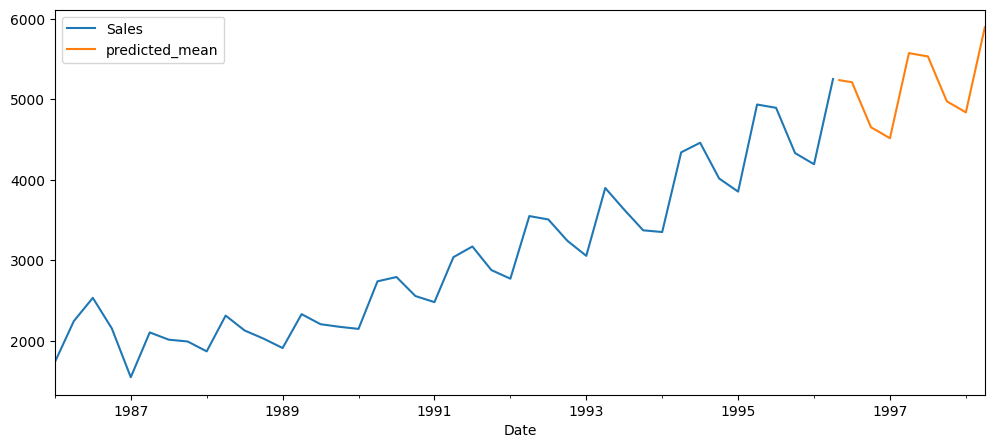

In [134]:
# Plot the forecast values by converting them into original scale
df['Sales'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

#  

## Data Pre-processing for model driven techniques

In [135]:
df1 = df.copy()
df1.reset_index(inplace = True)
df1

,Date,Sales
0,1986-01-31,1734.827000
1,1986-02-28,1904.871666
2,1986-03-31,2074.916332
3,1986-04-30,2244.960999
4,1986-05-31,2341.242330
...,...,...
119,1995-12-31,4240.333333
120,1996-01-31,4194.000000
121,1996-02-29,4547.000000
122,1996-03-31,4900.000000


In [136]:
df1['t'] = range(1, len(df1) + 1)
df1['log_sales'] = np.log(df1['Sales'])
df1['t_square'] = np.square(df1['t'])
df1

,Date,Sales,t,log_sales,t_square
0,1986-01-31,1734.827000,1,7.458663,1
1,1986-02-28,1904.871666,2,7.552170,4
2,1986-03-31,2074.916332,3,7.637676,9
3,1986-04-30,2244.960999,4,7.716443,16
4,1986-05-31,2341.242330,5,7.758437,25
...,...,...,...,...,...
119,1995-12-31,4240.333333,120,8.352397,14400
120,1996-01-31,4194.000000,121,8.341410,14641
121,1996-02-29,4547.000000,122,8.422223,14884
122,1996-03-31,4900.000000,123,8.496990,15129


In [137]:
df1["Month"] = df1.Date.dt.strftime("%b") # month extraction
df1["Year"] = df1.Date.dt.strftime("%Y") # year extraction
df1

,Date,Sales,t,log_sales,t_square,Month,Year
0,1986-01-31,1734.827000,1,7.458663,1,Jan,1986
1,1986-02-28,1904.871666,2,7.552170,4,Feb,1986
2,1986-03-31,2074.916332,3,7.637676,9,Mar,1986
3,1986-04-30,2244.960999,4,7.716443,16,Apr,1986
4,1986-05-31,2341.242330,5,7.758437,25,May,1986
...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,8.352397,14400,Dec,1995
120,1996-01-31,4194.000000,121,8.341410,14641,Jan,1996
121,1996-02-29,4547.000000,122,8.422223,14884,Feb,1996
122,1996-03-31,4900.000000,123,8.496990,15129,Mar,1996


In [138]:
# Creating dummy columns for each month
dummy_months = pd.get_dummies(df1['Month']).astype(int)

# Concatenating the dummy columns with the original DataFrame
df1 = pd.concat([df1, dummy_months], axis=1)

# Ordering the features
order = ['Date', 'Sales', 't', 'log_sales', 't_square', 'Year', 'Month', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df1 = df1[order]
df1

,Date,Sales,t,log_sales,t_square,Year,Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1986-01-31,1734.827000,1,7.458663,1,1986,Jan,1,0,0,0,0,0,0,0,0,0,0,0
1,1986-02-28,1904.871666,2,7.552170,4,1986,Feb,0,1,0,0,0,0,0,0,0,0,0,0
2,1986-03-31,2074.916332,3,7.637676,9,1986,Mar,0,0,1,0,0,0,0,0,0,0,0,0
3,1986-04-30,2244.960999,4,7.716443,16,1986,Apr,0,0,0,1,0,0,0,0,0,0,0,0
4,1986-05-31,2341.242330,5,7.758437,25,1986,May,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,8.352397,14400,1995,Dec,0,0,0,0,0,0,0,0,0,0,0,1
120,1996-01-31,4194.000000,121,8.341410,14641,1996,Jan,1,0,0,0,0,0,0,0,0,0,0,0
121,1996-02-29,4547.000000,122,8.422223,14884,1996,Feb,0,1,0,0,0,0,0,0,0,0,0,0
122,1996-03-31,4900.000000,123,8.496990,15129,1996,Mar,0,0,1,0,0,0,0,0,0,0,0,0


### Data Partition

#### Partitioning the data into an 80-20 split for training and testing purposes.

In [139]:
size = -16 #int(len(df)*0.8)

# Partition the data into train and test sets
Train = df1.iloc[:size]
Test = df1.iloc[size:]

In [140]:
# Print the lengths of train and test sets
print("Train set length:", len(Train))
print("Test set length:", len(Test))

Train set length: 108
Test set length: 16


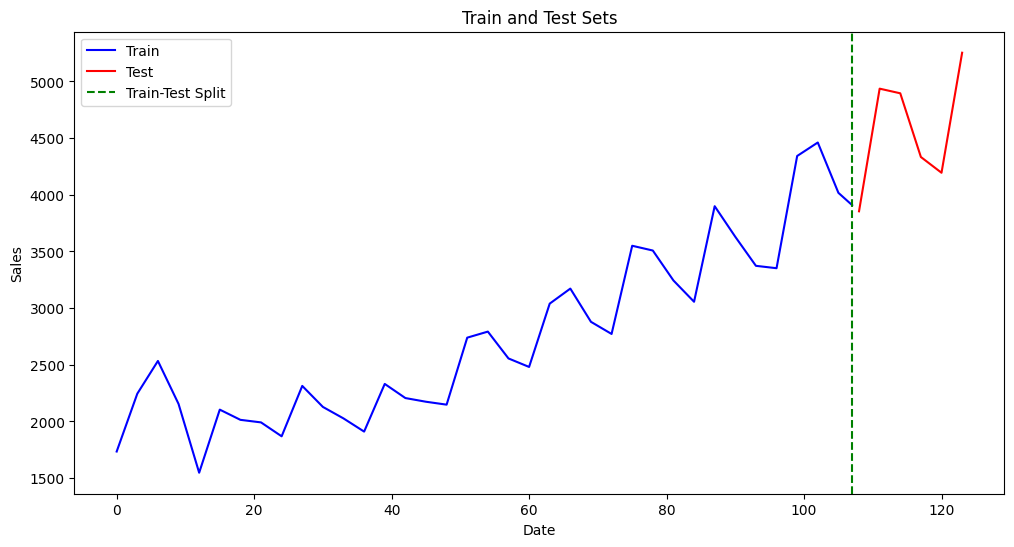

In [141]:
# Plotting train and test sets
plt.figure(figsize=(12, 6))
plt.plot(Train.index, Train['Sales'], label='Train', color = 'blue')
plt.plot(Test.index, Test['Sales'], label='Test', color = 'red')
plt.axvline(x=Train.index[-1], color='green', linestyle='--', label='Train-Test Split')
plt.title('Train and Test Sets')
plt.title('Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Building Equation based Forecasting Models

### 1. Linear model

In [142]:
import numpy as np
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
print('Linear Model RMSE:',rmse_linear)

Linear Model RMSE: 607.1719175421049


In [143]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     517.7
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.36e-42
Time:                        19:16:15   Log-Likelihood:                -770.60
No. Observations:                 108   AIC:                             1545.
Df Residuals:                     106   BIC:                             1551.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1576.5028     59.422     26.531      0.000    1458.693    1694.312
t             21.5342      0.946     22.754      0.000      19.658      23.411
==============================================================================
Omnibus:                        8.543   Durbin-Watson:                   0.171
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                9.095
Skew:                           0.708   Prob(JB):                       0.0106
Kurtosis:                       2.867   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

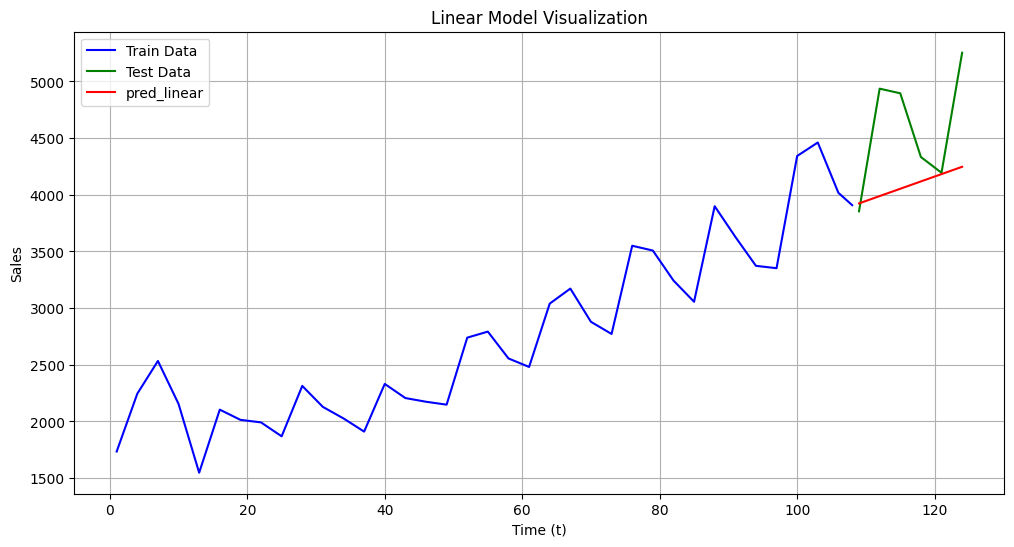

In [144]:
# Visualization
plt.figure(figsize=(12, 6))

# Plot actual train and test data
plt.plot(Train['t'], Train['Sales'], label='Train Data', color='blue')
plt.plot(Test['t'], Test['Sales'], label='Test Data', color='green')

# Plot predicted values
plt.plot(Test['t'], pred_linear, label='pred_linear', color='red')

plt.title('Linear Model Visualization')
plt.xlabel('Time (t)')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### 2. Exponential model

In [145]:
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
print('Exponential Model RMSE :',rmse_Exp)

Exponential Model RMSE : 464.9742006772838


In [146]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     562.4
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.47e-44
Time:                        19:16:16   Log-Likelihood:                 91.093
No. Observations:                 108   AIC:                            -178.2
Df Residuals:                     106   BIC:                            -172.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4656      0.020    366.613      0.000       7.425       7.506
t              0.0077      0.000     23.714      0.000       0.007       0.008
==============================================================================
Omnibus:                        7.786   Durbin-Watson:                   0.213
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.401
Skew:                           0.608   Prob(JB):                       0.0247
Kurtosis:                       3.406   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

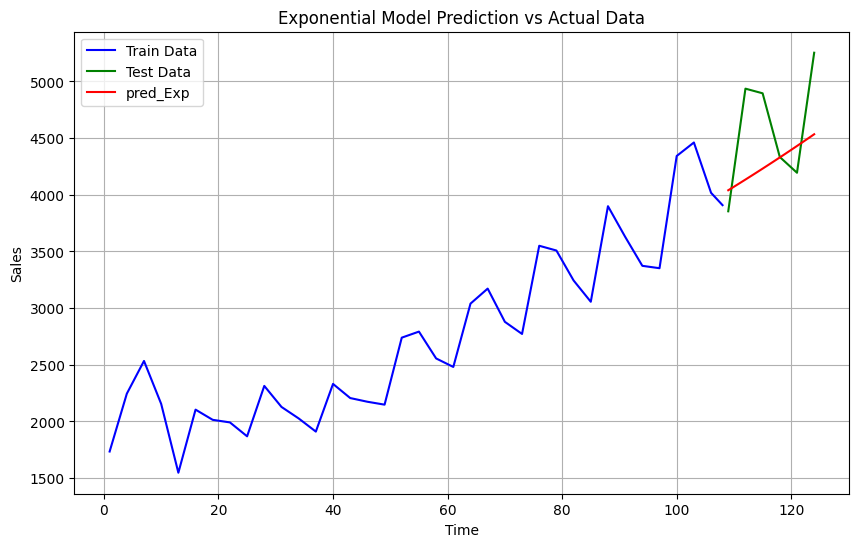

In [147]:
# Creating visualization
plt.figure(figsize=(10, 6))

# Plotting train and test data
plt.plot(Train['t'], Train['Sales'], label='Train Data', color='blue')
plt.plot(Test['t'], Test['Sales'], label='Test Data', color='green')

# Plotting predicted values from exponential model
plt.plot(Test['t'], np.exp(pred_Exp), label='pred_Exp', color='red')

plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Exponential Model Prediction vs Actual Data')
plt.legend()
plt.grid(True)
plt.show()

### 3. Quadratic Model

In [148]:
Quad = smf.ols('Sales~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
print('Quadratic RMSE :',rmse_Quad)

Quadratic RMSE : 404.95326317302124


In [149]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     465.8
Date:                Thu, 02 May 2024   Prob (F-statistic):           6.23e-53
Time:                        19:16:16   Log-Likelihood:                -742.66
No. Observations:                 108   AIC:                             1491.
Df Residuals:                     105   BIC:                             1499.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2020.3606     69.955     28.881      0.000    1881.653    2159.068
t             -2.6762      2.963     -0.903      0.368      -8.550       3.198
t_square       0.2221      0.026      8.435      0.000       0.170       0.274
==============================================================================
Omnibus:                        5.806   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                3.000
Skew:                           0.149   Prob(JB):                        0.223
Kurtosis:                       2.240   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

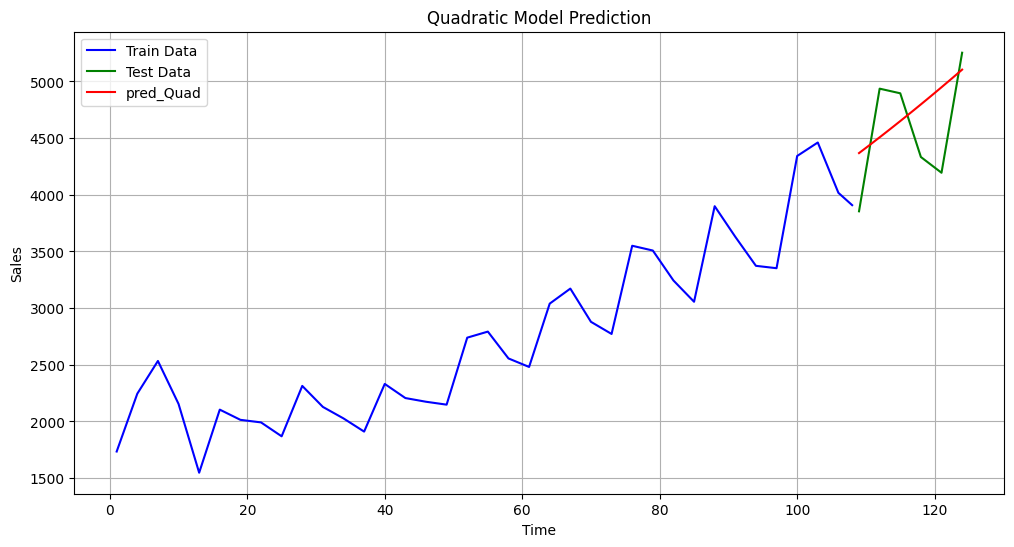

In [150]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting Train and test data
plt.plot(Train['t'], Train['Sales'], label='Train Data', color = 'blue')
plt.plot(Test['t'], Test['Sales'], label='Test Data', color = 'green')

# Plotting predicted values for test data
plt.plot(Test['t'], pred_Quad, label='pred_Quad', color='red')

plt.title('Quadratic Model Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### 4. Additive seasonality

In [151]:
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
print('Additive Seasonality RMSE : ',rmse_add_sea)

Additive Seasonality RMSE :  1870.4098028101719


In [152]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.6174
Date:                Thu, 02 May 2024   Prob (F-statistic):              0.810
Time:                        19:16:17   Log-Likelihood:                -862.61
No. Observations:                 108   AIC:                             1749.
Df Residuals:                      96   BIC:                             1781.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2607.3270    251.769     10.356      0.000    2107.570    3107.084
Jan         -288.2656    356.055     -0.810      0.420    -995.029     418.497
Feb          -77.4342    356.055     -0.217      0.828    -784.197     629.329
Mar          133.3973    356.055      0.375      0.709    -573.366     840.160
Apr          344.2287    356.055      0.967      0.336    -362.534    1050.992
May          339.8549    356.055      0.955      0.342    -366.908    1046.618
Jun          335.4811    356.055      0.942      0.348    -371.282    1042.244
Jul          331.1073    356.055      0.930      0.355    -375.656    1037.870
Aug          255.9395    356.055      0.719      0.474    -450.823     962.702
Sep          180.7717    356.055      0.508      0.613    -525.991     887.535
Oct          105.6039    356.055      0.297      0.767    -601.159     812.367
Nov           52.8020    356.055      0.148      0.882    -653.961     759.565
==============================================================================
Omnibus:                       17.230   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.327
Skew:                           0.546   Prob(JB):                      0.00943
Kurtosis:                       2.062   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

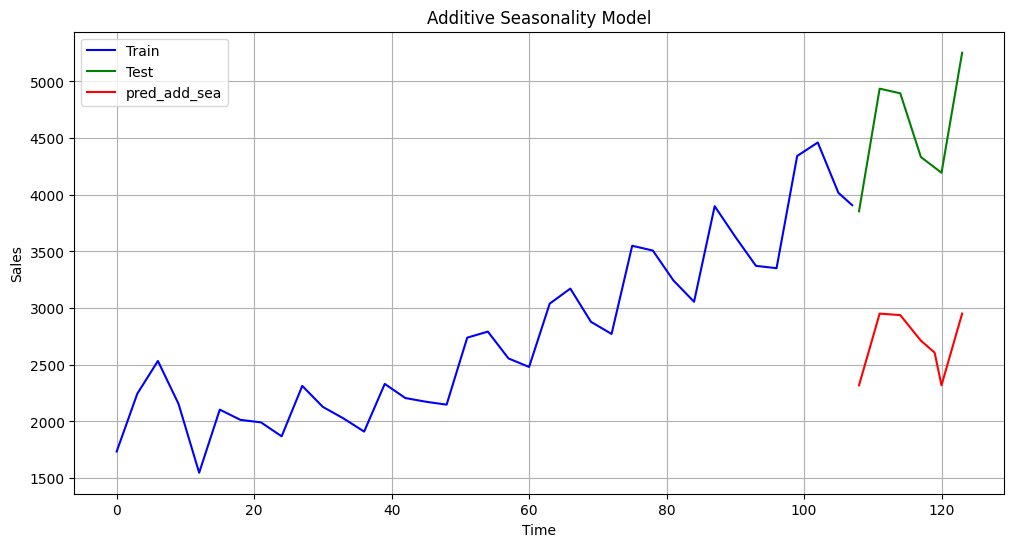

In [153]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot train and test data
plt.plot(Train['Sales'], label='Train', color='blue')
plt.plot(range(len(Train), len(Train) + len(Test)), Test['Sales'], label='Test', color='green')

# Plot predicted values
plt.plot(range(len(Train), len(Train) + len(Test)), pred_add_sea, label='pred_add_sea', color='red')

plt.title('Additive Seasonality Model')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### 5. Additive Seasonality with Quadratic Trend

In [154]:
add_sea_Quad = smf.ols('Sales~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
print('Additive Seasonality with Quadratic Trend RMSE :',rmse_add_sea_quad)

Additive Seasonality with Quadratic Trend RMSE : 251.75068089310085


In [155]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     207.5
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.94e-63
Time:                        19:16:17   Log-Likelihood:                -683.18
No. Observations:                 108   AIC:                             1394.
Df Residuals:                      94   BIC:                             1432.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1751.8824     63.816     27.452      0.000    1625.175    1878.590
t             -2.8095      1.806     -1.556      0.123      -6.395       0.776
t_square       0.2246      0.016     13.996      0.000       0.193       0.256
Jan          -49.9170     68.499     -0.729      0.468    -185.923      86.089
Feb          141.4920     68.468      2.067      0.042       5.548     277.436
Mar          332.4519     68.440      4.858      0.000     196.562     468.341
Apr          522.9627     68.415      7.644      0.000     387.122     658.803
May          497.8191     68.394      7.279      0.000     362.022     633.616
Jun          472.2264     68.375      6.906      0.000     336.467     607.986
Jul          446.1845     68.358      6.527      0.000     310.458     581.911
Aug          348.8995     68.345      5.105      0.000     213.199     484.600
Sep          251.1654     68.334      3.676      0.000     115.487     386.844
Oct          152.9822     68.326      2.239      0.028      17.319     288.645
Nov           76.7157     68.321      1.123      0.264     -58.938     212.369
==============================================================================
Omnibus:                        1.571   Durbin-Watson:                   0.160
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.339
Skew:                          -0.104   Prob(JB):                        0.512
Kurtosis:                       2.496   Cond. No.                     6.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

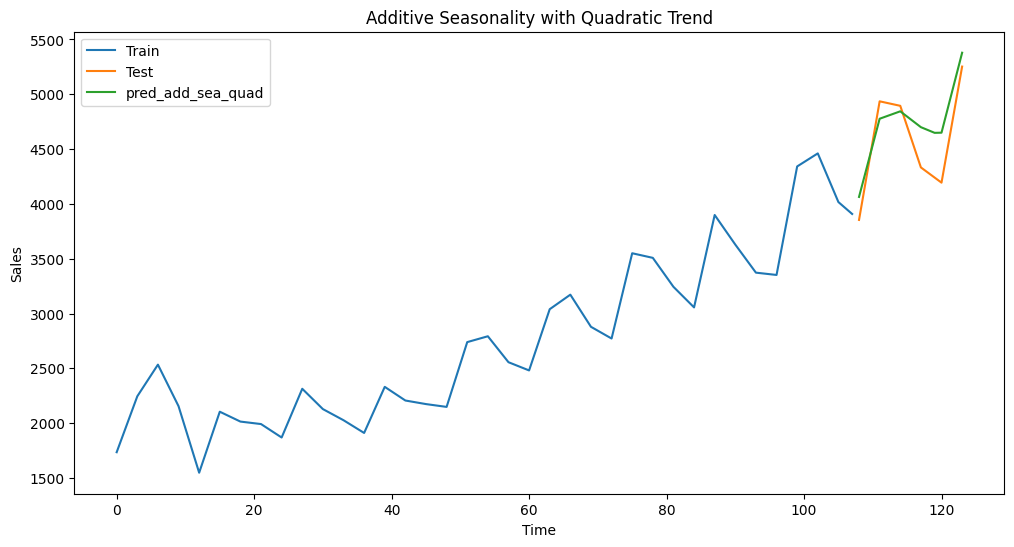

In [156]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(Train['Sales'], label='Train')
plt.plot(Test.index, Test['Sales'], label='Test')

# Plot predicted data
plt.plot(Test.index, pred_add_sea_quad, label='pred_add_sea_quad')

plt.title('Additive Seasonality with Quadratic Trend')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

### 6. Multiplicative Seasonality

In [157]:
Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
print('Multiplicative Seasonality RMSE:',rmse_Mult_sea)

Multiplicative Seasonality RMSE: 1956.365744960709


In [158]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.6985
Date:                Thu, 02 May 2024   Prob (F-statistic):              0.737
Time:                        19:16:17   Log-Likelihood:                -4.1847
No. Observations:                 108   AIC:                             32.37
Df Residuals:                      96   BIC:                             64.55
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8307      0.089     88.055      0.000       7.654       8.007
Jan           -0.1140      0.126     -0.906      0.367      -0.364       0.136
Feb           -0.0267      0.126     -0.213      0.832      -0.276       0.223
Mar            0.0534      0.126      0.424      0.672      -0.196       0.303
Apr            0.1275      0.126      1.014      0.313      -0.122       0.377
May            0.1258      0.126      1.001      0.320      -0.124       0.375
Jun            0.1238      0.126      0.984      0.328      -0.126       0.373
Jul            0.1213      0.126      0.964      0.337      -0.128       0.371
Aug            0.0970      0.126      0.771      0.443      -0.153       0.347
Sep            0.0719      0.126      0.571      0.569      -0.178       0.321
Oct            0.0459      0.126      0.365      0.716      -0.204       0.295
Nov            0.0236      0.126      0.188      0.851      -0.226       0.273
==============================================================================
Omnibus:                       58.740   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.871
Skew:                           0.284   Prob(JB):                       0.0119
Kurtosis:                       1.716   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

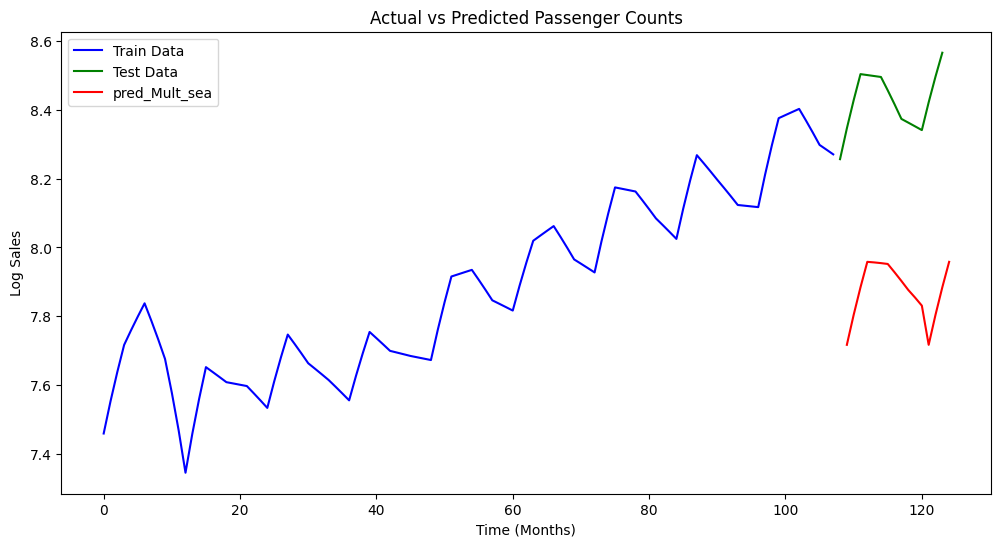

In [159]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting actual train and test data
plt.plot(Train['log_sales'], label='Train Data', color='blue')
plt.plot(range(len(Train['log_sales']), len(Train['log_sales'])+len(Test['log_sales'])),
         Test['log_sales'], label='Test Data', color='green')

# Plotting predicted values
plt.plot(range(len(Train['log_sales'])+1, len(Train['log_sales'])+len(Test['log_sales'])+1),
         pred_Mult_sea, label='pred_Mult_sea', color='red')

plt.xlabel('Time (Months)')
plt.ylabel('Log Sales')
plt.title('Actual vs Predicted Passenger Counts')
plt.legend()
plt.show()

### 7. Multiplicative Additive Seasonality

In [160]:
Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print('Multiplicative Additive Seasonality RMSE :',rmse_Mult_add_sea)

Multiplicative Additive Seasonality RMSE : 299.6327457805418


In [161]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     83.89
Date:                Thu, 02 May 2024   Prob (F-statistic):           4.88e-45
Time:                        19:16:18   Log-Likelihood:                 124.00
No. Observations:                 108   AIC:                            -222.0
Df Residuals:                      95   BIC:                            -187.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3668      0.031    235.703      0.000       7.305       7.429
t              0.0077      0.000     30.415      0.000       0.007       0.008
Jan           -0.0290      0.039     -0.749      0.456      -0.106       0.048
Feb            0.0506      0.039      1.308      0.194      -0.026       0.127
Mar            0.1230      0.039      3.181      0.002       0.046       0.200
Apr            0.1893      0.039      4.900      0.000       0.113       0.266
May            0.1799      0.039      4.659      0.000       0.103       0.257
Jun            0.1702      0.039      4.407      0.000       0.093       0.247
Jul            0.1599      0.039      4.143      0.000       0.083       0.237
Aug            0.1279      0.039      3.314      0.001       0.051       0.205
Sep            0.0950      0.039      2.463      0.016       0.018       0.172
Oct            0.0613      0.039      1.589      0.115      -0.015       0.138
Nov            0.0314      0.039      0.813      0.419      -0.045       0.108
==============================================================================
Omnibus:                       18.100   Durbin-Watson:                   0.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.406
Skew:                           0.872   Prob(JB):                     8.27e-06
Kurtosis:                       4.470   Cond. No.                         785.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

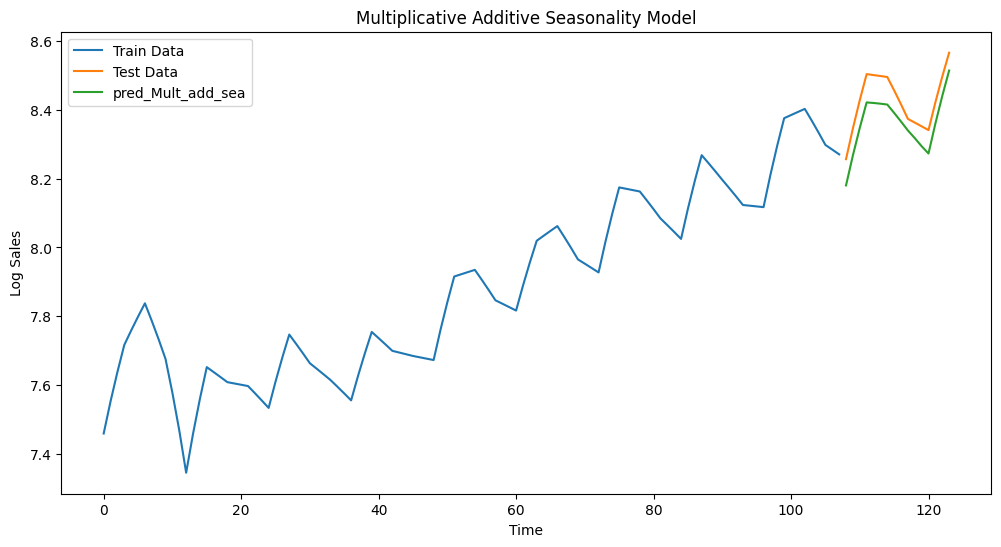

In [162]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))

# Plot actual train and test data
plt.plot(Train['log_sales'], label='Train Data')
plt.plot(range(len(Train), len(Train) + len(Test)), Test['log_sales'], label='Test Data')

# Plot predicted values
plt.plot(range(len(Train), len(Train) + len(Test)), pred_Mult_add_sea, label='pred_Mult_add_sea')

plt.title('Multiplicative Additive Seasonality Model')
plt.xlabel('Time')
plt.ylabel('Log Sales')
plt.legend()
plt.show()

In [163]:
#Compare the results
data2 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
         "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
type(data2)

table_rmse2 = pd.DataFrame(data2)
table_rmse2.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,251.750681
6,rmse_Mult_add_sea,299.632746
2,rmse_Quad,404.953263
1,rmse_Exp,464.974201
0,rmse_linear,607.171918
3,rmse_add_sea,1870.409803
5,rmse_Mult_sea,1956.365745


### RMSE table for all models

In [164]:
table_RMSE = pd.concat([table_rmse1, table_rmse2], ignore_index=True)

# Sorting concatenated DataFrame by RMSE_Values
table_RMSE = table_RMSE.sort_values(by='RMSE_Values')
table_RMSE

,MODEL,RMSE_Values
5,SARIMA,110.734086
10,rmse_add_sea_quad,251.750681
12,rmse_Mult_add_sea,299.632746
4,hwe_model_add_add,309.394200
3,Holt,387.312263
8,rmse_Quad,404.953263
7,rmse_Exp,464.974201
2,ARIMA,583.021180
6,rmse_linear,607.171918
1,SES,645.771538


## Visualizing Models Performance

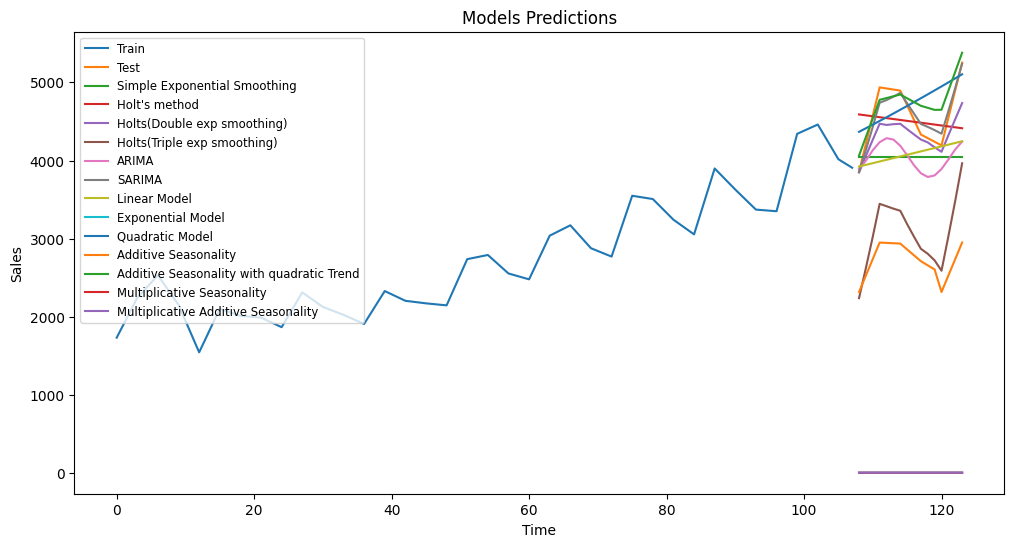

In [165]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(Train['Sales'], label='Train')
plt.plot(Test.index, Test['Sales'], label='Test')

# Plot predicted data
plt.plot(Test.index, pred_ses, label='Simple Exponential Smoothing')
plt.plot(Test.index, pred_hw, label="Holt's method")
plt.plot(Test.index, pred_hwe_add_add, label='Holts(Double exp smoothing)')
plt.plot(Test.index, pred_hwe_mul_add, label='Holts(Triple exp smoothing)')
plt.plot(Test.index, arima_predictions, label='ARIMA')
plt.plot(Test.index, sarima_predictions, label='SARIMA')
plt.plot(Test.index, pred_linear, label='Linear Model')
plt.plot(Test.index, pred_Exp, label='Exponential Model')
plt.plot(Test.index, pred_Quad, label='Quadratic Model')
plt.plot(Test.index, pred_add_sea, label='Additive Seasonality')
plt.plot(Test.index, pred_add_sea_quad, label='Additive Seasonality with quadratic Trend')
plt.plot(Test.index, pred_Mult_sea, label='Multiplicative Seasonality')
plt.plot(Test.index, pred_Mult_add_sea, label='Multiplicative Additive Seasonality')

plt.title('Models Predictions')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc = 'best', fontsize='small')
plt.show()

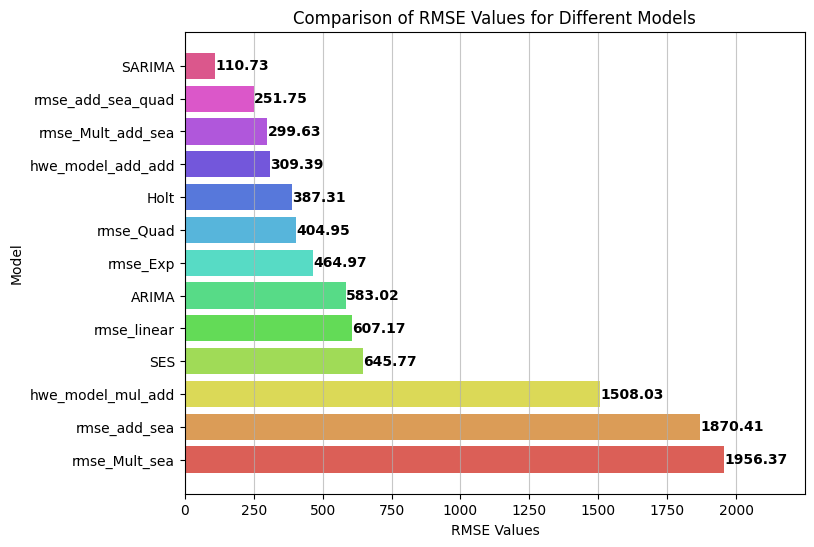

In [166]:
# Sort DataFrame by RMSE values in ascending order
table_RMSE = table_RMSE.sort_values(by='RMSE_Values', ascending=False)

# Create a color palette using seaborn's 'hls' palette
colors = sns.color_palette('hls', len(table_RMSE))

# Create visualization with the 'hls' palette
plt.figure(figsize=(8, 6))
bars = plt.barh(table_RMSE['MODEL'], table_RMSE['RMSE_Values'], color=colors)
plt.xlabel('RMSE Values')
plt.ylabel('Model')
plt.title('Comparison of RMSE Values for Different Models')
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Add RMSE values next to the bars
for bar, value in zip(bars, table_RMSE['RMSE_Values']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', fontweight='bold')

# Adjust x-axis limits to accommodate annotations
plt.xlim(0, max(table_RMSE['RMSE_Values']) * 1.15)
plt.show()

## **SARIMA** has the lowest RMSE, making it our best model so far.